#Wine Quality Dataset for regression


In [1]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo
!pip install /notebooks/pyade-master

#Import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG


Processing ./pyade-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyade-python: filename=pyade_python-1.0-py3-none-any.whl size=29472 sha256=f2719454005f5085778dcda16a30d49d7e0a9793a23c09fc76aa708e2f9e1a4d
  Stored in directory: /root/.cache/pip/wheels/98/25/f0/ab5adf3c6041d02e08073e288b6daf66206788126fdc60b442
Successfully built pyade-python
  Attempting uninstall: pyade-python
    Found existing installation: pyade-python 1.0
    Uninstalling pyade-python-1.0:
      Successfully uninstalled pyade-python-1.0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

utilsTFG.set_seed()

cuda


### Datos y modelos

In [3]:
dataset = 'wqr'
plot_dataset='WQR'

#Download the dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)

X = wine_quality.data.features
y = wine_quality.data.targets

#Show the data
print(X.head())



# Define the categorical and continuous variables
cat_names = []
cont_names = list(X.columns)
dep_var = 'quality'


df=pd.concat([X, y], axis=1)

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)




   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4  
{'uci_id

In [4]:
#Show if there is missing data
missing_values = df.isna().sum()
print(missing_values)

#Handle the missing data, filling with the mean
#mis_col = []
#df[mis_col] = df[mis_col].fillna(df.mean())


fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [5]:
# Split indices for training, validation, and test sets
train_val_split = RandomSplitter(valid_pct=0.3, seed=42)(range_of(df))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (~20% test ~10% validation)
val_test_split = RandomSplitter(valid_pct=0.7, seed=42)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

# Create DataFrames for the splits
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
test_df = df.iloc[test_idx]

quality                 1.000000
alcohol                 0.438457
density                 0.292773
volatile_acidity        0.277925
chlorides               0.194056
citric_acid             0.090079
fixed_acidity           0.076022
sulphates               0.068103
free_sulfur_dioxide     0.065538
total_sulfur_dioxide    0.037923
residual_sugar          0.029202
pH                      0.018818
dtype: float64


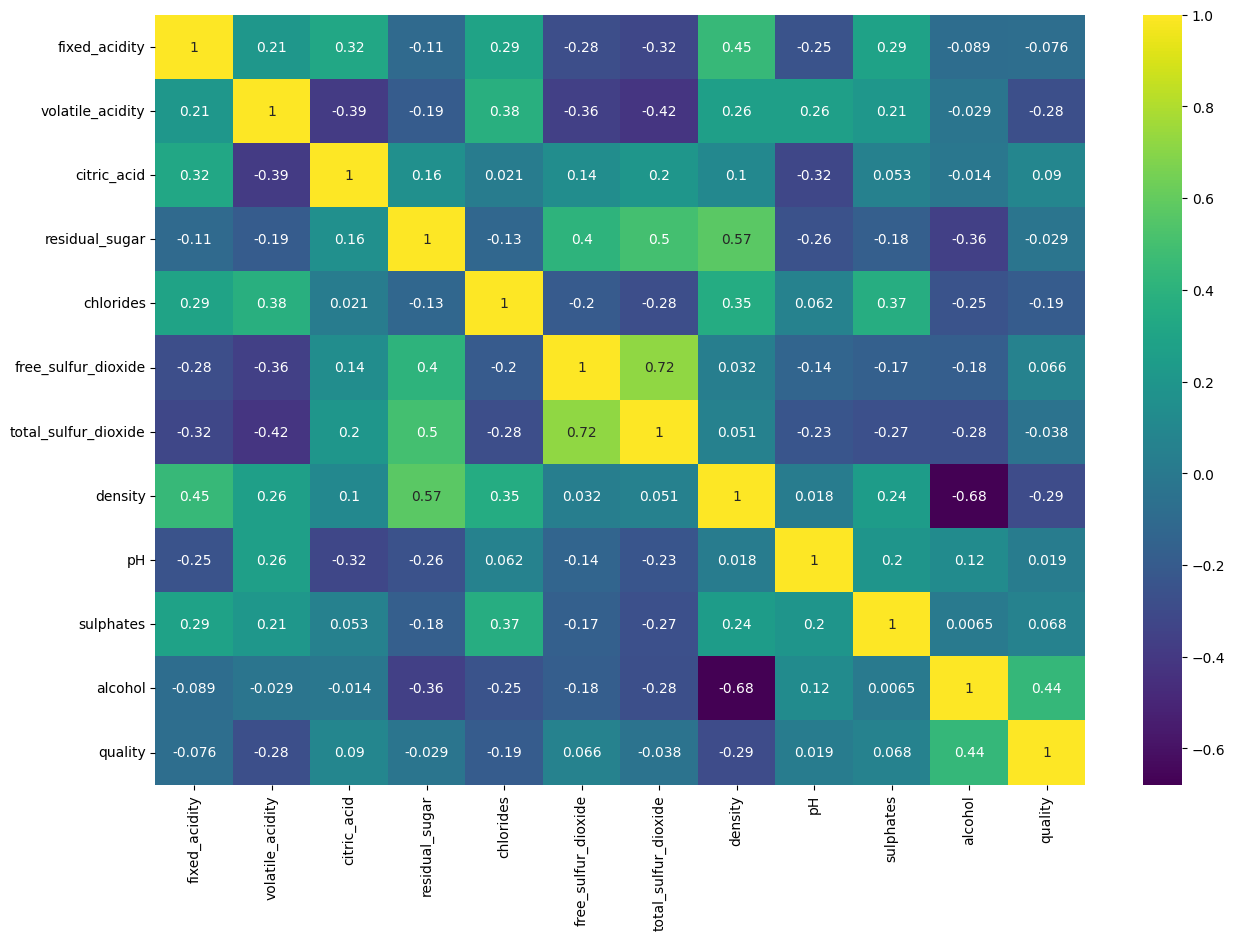

In [6]:
##Preprocessing

#Correlation of all features with the target
corr_mat = train_df.corr()[dep_var]
target_corr = np.abs(train_df.corrwith(train_df[dep_var]))
print(target_corr.sort_values(ascending=False))

#Correlation of features with each other
corr_matrix = train_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,cmap="viridis", annot=True)
plt.show()



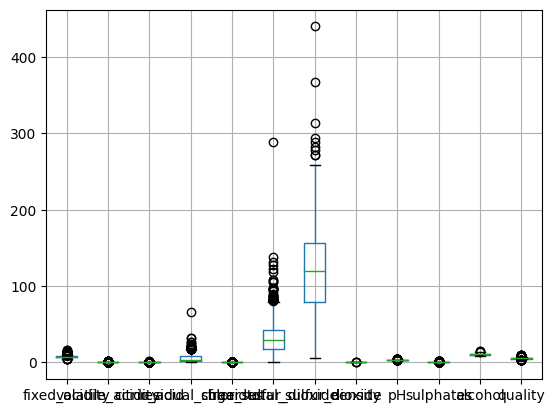

In [7]:
#Boxplot to see the range of feature values
train_df.boxplot()
plt.show()

In [8]:
#Drop features with low correlation with the target
features_to_drop = target_corr[target_corr < 0.05].index
train_df = train_df.drop(columns=features_to_drop)
val_df = val_df.drop(columns=features_to_drop)
test_df = test_df.drop(columns=features_to_drop)
cont_names = [col for col in cont_names if col not in features_to_drop]
print(f"Variables eliminadas: {features_to_drop}")

Variables eliminadas: Index(['residual_sugar', 'total_sulfur_dioxide', 'pH'], dtype='object')


In [9]:
# Correlation matrix of the training set
corr_matrix = train_df.corr()
threshold = 0.9

# Find pairs of features with correlation above the threshold
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > threshold]

to_drop = set()

for i, j in high_corr_pairs:
    if i not in to_drop and j not in to_drop:
        # Add one of the features to the drop list
        to_drop.add(j)

# Drop the identified features from the DataFrames
train_df.drop(columns=to_drop, inplace=True)
val_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)

# Update the list of continuous names
cont_names = [col for col in cont_names if col not in to_drop]

# Print the dropped features for reference
print(f"Variables eliminadas: {to_drop}")

Variables eliminadas: set()


In [10]:
def remove_outliers(df, factor):
    for col in df:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR= Q3-Q1
    
        lim_inf = Q1 - factor*IQR
        lim_sup = Q3 + factor*IQR

        #Nos quedamos con los datos que no sean outliers con calidad 5,6,7 y con los datos con calidad 3,4,8,9 independientemente de si son outliers
        df = df[((df[col] >= lim_inf) & (df[col] <= lim_sup)) | (df['quality'].isin([3,4,8,9]))]
    return df

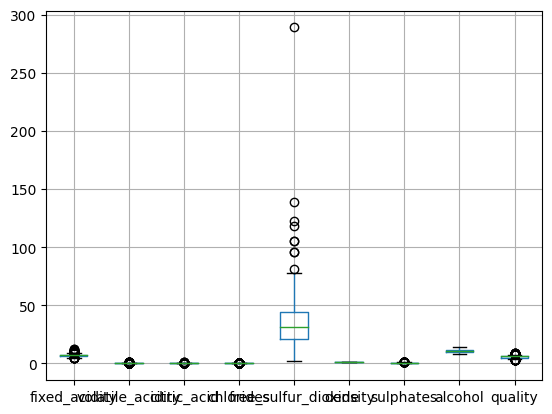

In [11]:
train_df_no_outliers = remove_outliers(train_df, 1.5)

train_df_no_outliers.boxplot()
plt.show()

In [12]:
# Normalize the continuous features
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
train_df_no_outliers.loc[:,cont_names] = scaler.fit_transform(train_df_no_outliers.loc[:,cont_names])

# Transform the validation and test data
val_df.loc[:,cont_names] = scaler.transform(val_df.loc[:,cont_names])
test_df.loc[:,cont_names] = scaler.transform(test_df.loc[:,cont_names])


train_df_no_outliers = train_df_no_outliers.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Combine all indices for the splits
splits = (list(train_df_no_outliers.index), list(val_df.index))

# Concatenate the DataFrames back together
df_c = pd.concat([train_df_no_outliers, val_df])

# Create TabularPandas for training and validation
to = TabularPandas(
    df_c,
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)

# Create DataLoaders for training and validation
dls = to.dataloaders(bs=64, shuffle=True)

# Create TabularPandas for the test set
test_to = TabularPandas(
    test_df,  # Select only the test data
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=64, shuffle=False)
dls.to(device)
test_dl.to(device)

In [13]:
#Initialise arrays for the loops
layers = [[64], [64, 64], [ 64, 128, 256, 128, 64], [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32] ]
n_layers=[1,2,5,11]
optims = ['NAG', 'RMSProp', 'ADAM', 'ADAMW']
names_layer=['1 capa', '2 capas', '5 capas', '11 capas']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['AdjR2Sq']
init_weights = {}
for layer in n_layers:
  init_weights[layer] = {}

In [14]:
#For each number of layers initialise the model with the same parameters.
for layer in layers:
  learn = tabular_learner(dls, layers=layer, n_out=1, metrics=utilsTFG.AdjustedR2Score, loss_func=MSELossFlat())
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[len(layer)] = utilsTFG.get_params_from_model(learn.model)

  print(learn.summary())

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 1              
Linear                                    65         True      
____________________________________________________________________________

Total params: 721
Total trainable params: 721
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fc790dab1a0>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - CastToTensor
  -

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               128        True      
Linear                                    4096       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 1              
Linear                                    65         True      
____________________________________________________________________________

Total params: 4,945
Total train

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     64 x 256            
Linear                                    32768      T

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     64 x 32             
Linear                                    256        True      
ReLU                                                           
BatchNorm1d                               64         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    2048       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       T

## Gradient Descent

In [15]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
ADAMW = partial(OptimWrapper, opt=torch.optim.AdamW)
optims2 = [NAG, RMSProp, ADAM, ADAMW]
utilsTFG.set_seed()

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, n_out=1, loss_func = MSELossFlat(), metrics=utilsTFG.AdjustedR2Score, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][len(layer)].to(device)
        learners[opt][len(layer)].model.to(device)
        utilsTFG.set_params_to_model(init_weights[len(layer)], learners[opt][len(layer)].model)


In [16]:
#To check if the models have the same initial parameters
for layer in n_layers:
  if utilsTFG.compare_models(learners['NAG'][layer], learners['RMSProp'][layer]) and utilsTFG.compare_models(learners['NAG'][layer], learners['ADAM'][layer]) and utilsTFG.compare_models(learners['ADAM'][layer], learners['RMSProp'][layer]):
    print(f"Mismos parámetros en capa {layer}.")
  else:
    print("Distintos parámetros.")


Mismos parámetros en capa 1.
Mismos parámetros en capa 2.
Mismos parámetros en capa 5.
Mismos parámetros en capa 11.


### Nesterov

Better model found at epoch 0 with valid_loss value: 27.1358642578125.
Better model found at epoch 1 with valid_loss value: 7.974244594573975.
Better model found at epoch 2 with valid_loss value: 0.9177824258804321.
Better model found at epoch 3 with valid_loss value: 0.7679834365844727.
Better model found at epoch 4 with valid_loss value: 0.7073506116867065.
Better model found at epoch 5 with valid_loss value: 0.696869432926178.
Better model found at epoch 6 with valid_loss value: 0.6643456220626831.
Better model found at epoch 7 with valid_loss value: 0.6463537216186523.
Better model found at epoch 8 with valid_loss value: 0.6303030252456665.
Better model found at epoch 9 with valid_loss value: 0.6278804540634155.
Better model found at epoch 11 with valid_loss value: 0.6227242350578308.
Better model found at epoch 12 with valid_loss value: 0.6168562769889832.
Better model found at epoch 16 with valid_loss value: 0.6102953553199768.
Better model found at epoch 17 with valid_loss value

Better model found at epoch 0 with valid_loss value: 27.243452072143555.
Better model found at epoch 1 with valid_loss value: 7.544802665710449.
Better model found at epoch 2 with valid_loss value: 0.8649464249610901.
Better model found at epoch 3 with valid_loss value: 0.7677688002586365.
Better model found at epoch 4 with valid_loss value: 0.6856696009635925.
Better model found at epoch 5 with valid_loss value: 0.6514658331871033.
Better model found at epoch 6 with valid_loss value: 0.6358793377876282.
Better model found at epoch 7 with valid_loss value: 0.6078957319259644.
Better model found at epoch 8 with valid_loss value: 0.5752835869789124.
Better model found at epoch 9 with valid_loss value: 0.5679181218147278.
Better model found at epoch 10 with valid_loss value: 0.5647494196891785.
Better model found at epoch 11 with valid_loss value: 0.5542603731155396.
Better model found at epoch 12 with valid_loss value: 0.5460700392723083.
Better model found at epoch 13 with valid_loss va

Better model found at epoch 0 with valid_loss value: 26.6868953704834.
Better model found at epoch 1 with valid_loss value: 7.033112049102783.
Better model found at epoch 2 with valid_loss value: 0.8195648193359375.
Better model found at epoch 3 with valid_loss value: 0.6253092885017395.
Better model found at epoch 4 with valid_loss value: 0.5499295592308044.
Better model found at epoch 5 with valid_loss value: 0.5055389404296875.
Better model found at epoch 6 with valid_loss value: 0.4622766673564911.
Better model found at epoch 7 with valid_loss value: 0.4445348381996155.
Better model found at epoch 8 with valid_loss value: 0.41968655586242676.
Better model found at epoch 9 with valid_loss value: 0.4160136282444.
Better model found at epoch 10 with valid_loss value: 0.39522063732147217.
Better model found at epoch 11 with valid_loss value: 0.37031862139701843.
Better model found at epoch 12 with valid_loss value: 0.36100244522094727.
Better model found at epoch 14 with valid_loss val

Better model found at epoch 0 with valid_loss value: 27.504629135131836.
Better model found at epoch 1 with valid_loss value: 8.098352432250977.
Better model found at epoch 2 with valid_loss value: 1.1542948484420776.
Better model found at epoch 3 with valid_loss value: 0.7307264804840088.
Better model found at epoch 4 with valid_loss value: 0.5473446846008301.
Better model found at epoch 5 with valid_loss value: 0.5243856310844421.
Better model found at epoch 6 with valid_loss value: 0.46979740262031555.
Better model found at epoch 7 with valid_loss value: 0.4524017572402954.
Better model found at epoch 8 with valid_loss value: 0.4342826008796692.
Better model found at epoch 10 with valid_loss value: 0.410424143075943.
Better model found at epoch 11 with valid_loss value: 0.37221717834472656.
Better model found at epoch 13 with valid_loss value: 0.3685494661331177.
Better model found at epoch 15 with valid_loss value: 0.337411105632782.
Better model found at epoch 16 with valid_loss v

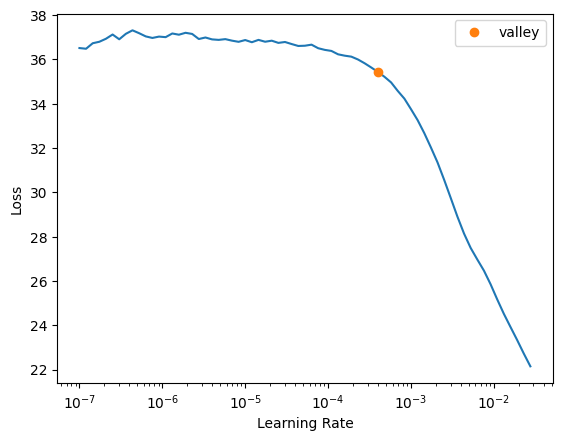

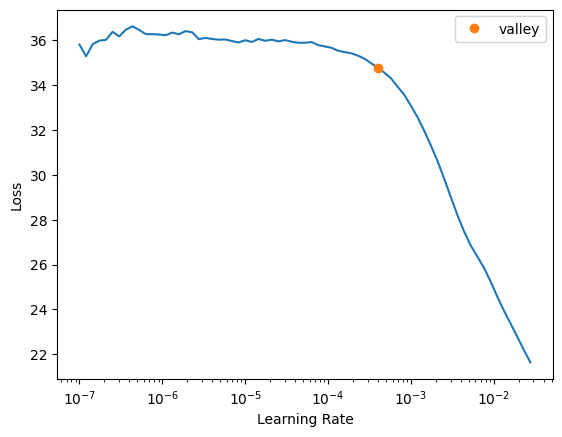

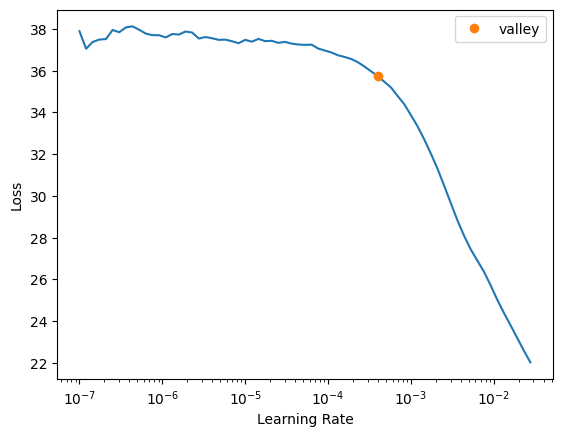

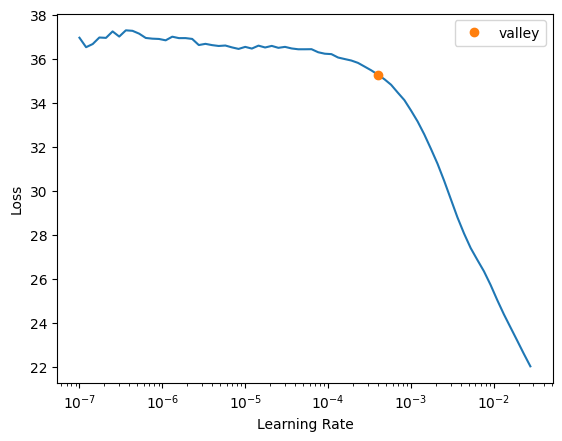

In [17]:
#Run the training and measure the time for each layer
for layer, learner in learners['NAG'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][layer] = end-start



<Figure size 1200x600 with 0 Axes>

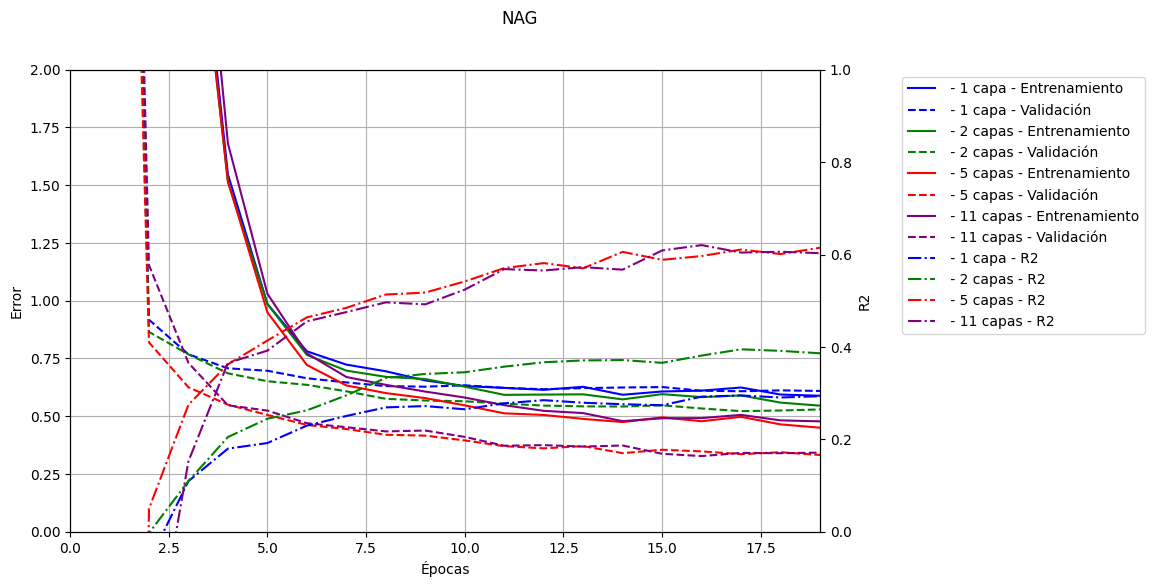

In [18]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), lim = 2, title='NAG', names=names_layer, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 0.9448018670082092.
Better model found at epoch 1 with valid_loss value: 0.7122874855995178.
Better model found at epoch 2 with valid_loss value: 0.6949415802955627.
Better model found at epoch 3 with valid_loss value: 0.6719869375228882.
Better model found at epoch 4 with valid_loss value: 0.6250734925270081.
Better model found at epoch 5 with valid_loss value: 0.571027934551239.
Better model found at epoch 8 with valid_loss value: 0.5525998473167419.
Better model found at epoch 11 with valid_loss value: 0.5516108870506287.
Better model found at epoch 12 with valid_loss value: 0.5513299107551575.
Better model found at epoch 15 with valid_loss value: 0.5185825228691101.
Better model found at epoch 16 with valid_loss value: 0.5176293253898621.
Better model found at epoch 17 with valid_loss value: 0.5146005749702454.
Better model found at epoch 18 with valid_loss value: 0.5049059987068176.
Better model found at epoch 19 with valid_loss

Better model found at epoch 0 with valid_loss value: 6.592298984527588.
Better model found at epoch 1 with valid_loss value: 0.8260249495506287.
Better model found at epoch 3 with valid_loss value: 0.7142509818077087.
Better model found at epoch 4 with valid_loss value: 0.6681963205337524.
Better model found at epoch 5 with valid_loss value: 0.5515377521514893.
Better model found at epoch 9 with valid_loss value: 0.5189861059188843.
Better model found at epoch 11 with valid_loss value: 0.518829882144928.
Better model found at epoch 14 with valid_loss value: 0.5148652195930481.
Better model found at epoch 16 with valid_loss value: 0.47174718976020813.
Better model found at epoch 17 with valid_loss value: 0.46818289160728455.
Better model found at epoch 18 with valid_loss value: 0.451311320066452.
Better model found at epoch 19 with valid_loss value: 0.4488925635814667.


Better model found at epoch 0 with valid_loss value: 9.577740669250488.
Better model found at epoch 1 with valid_loss value: 0.8075066804885864.
Better model found at epoch 2 with valid_loss value: 0.7058671712875366.
Better model found at epoch 3 with valid_loss value: 0.6122596859931946.
Better model found at epoch 4 with valid_loss value: 0.5564174652099609.
Better model found at epoch 9 with valid_loss value: 0.5465193390846252.
Better model found at epoch 11 with valid_loss value: 0.5344713926315308.
Better model found at epoch 12 with valid_loss value: 0.5080642104148865.
Better model found at epoch 14 with valid_loss value: 0.5069739818572998.
Better model found at epoch 16 with valid_loss value: 0.44450095295906067.
Better model found at epoch 17 with valid_loss value: 0.4324350357055664.
Better model found at epoch 18 with valid_loss value: 0.4228877127170563.
Better model found at epoch 19 with valid_loss value: 0.4143516421318054.


Better model found at epoch 0 with valid_loss value: 12.167122840881348.
Better model found at epoch 1 with valid_loss value: 0.812551736831665.
Better model found at epoch 2 with valid_loss value: 0.7387331128120422.
Better model found at epoch 3 with valid_loss value: 0.6060032844543457.
Better model found at epoch 7 with valid_loss value: 0.5806087851524353.
Better model found at epoch 13 with valid_loss value: 0.5800447463989258.
Better model found at epoch 17 with valid_loss value: 0.5430808067321777.
Better model found at epoch 18 with valid_loss value: 0.5336192846298218.
Better model found at epoch 19 with valid_loss value: 0.5255451798439026.


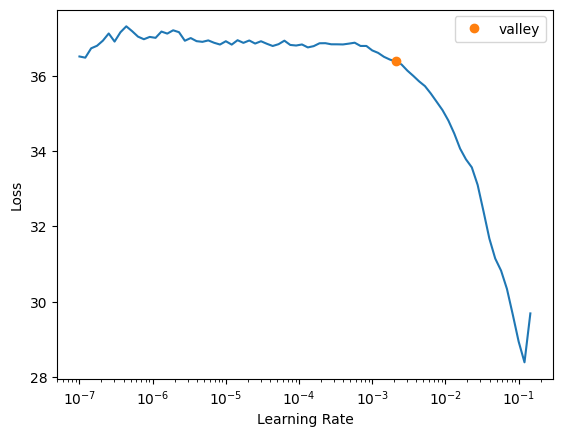

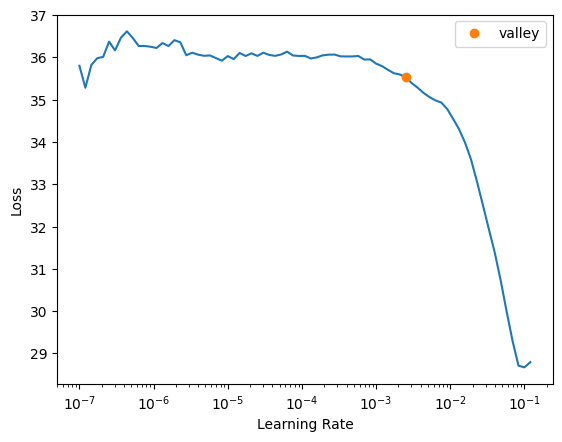

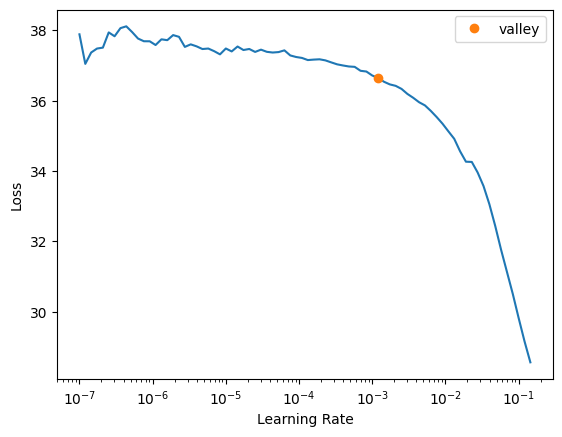

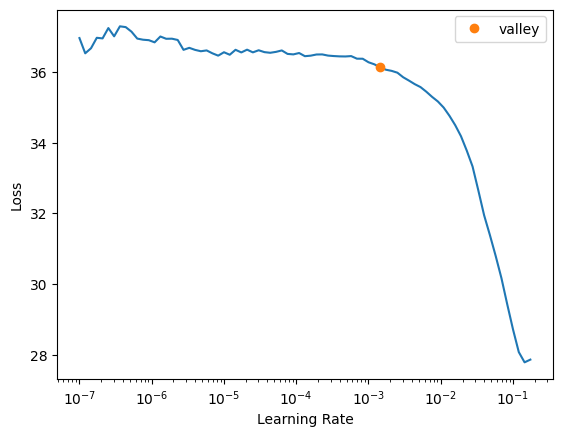

In [19]:
#Run the training and measure the time for each layer
for layer, learner in learners['RMSProp'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][layer] = end-start


<Figure size 1200x600 with 0 Axes>

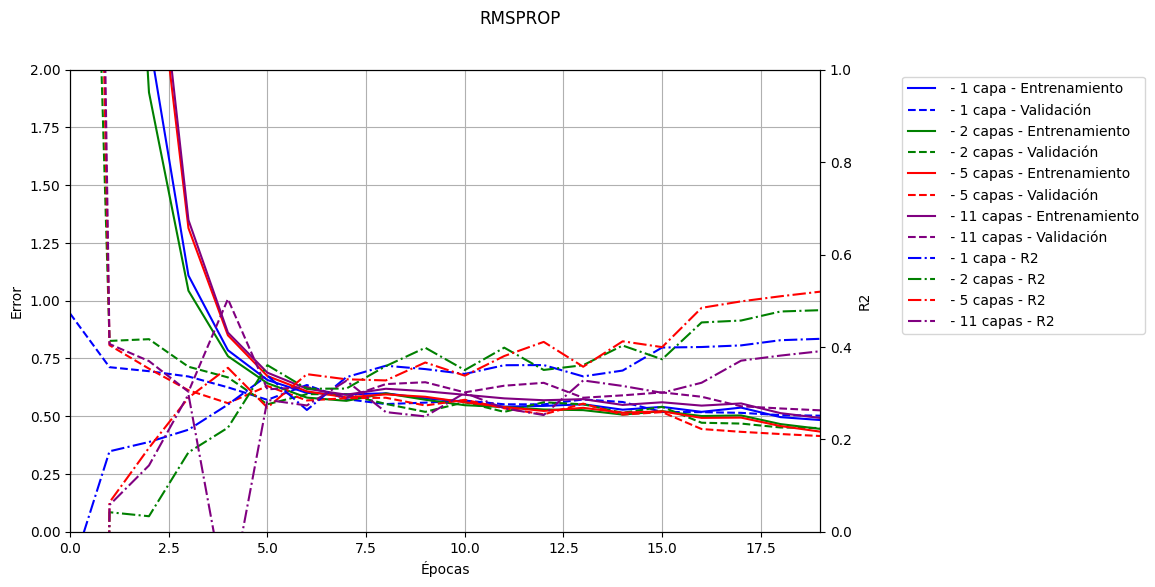

In [20]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), lim = 2, title='RMSPROP', names=names_layer, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 30.962602615356445.
Better model found at epoch 1 with valid_loss value: 15.1417236328125.
Better model found at epoch 2 with valid_loss value: 0.9602898955345154.
Better model found at epoch 3 with valid_loss value: 0.7284038662910461.
Better model found at epoch 4 with valid_loss value: 0.6653602719306946.
Better model found at epoch 5 with valid_loss value: 0.6187992095947266.
Better model found at epoch 7 with valid_loss value: 0.5520292520523071.
Better model found at epoch 9 with valid_loss value: 0.5467419624328613.
Better model found at epoch 12 with valid_loss value: 0.5333269238471985.
Better model found at epoch 14 with valid_loss value: 0.5189182162284851.
Better model found at epoch 16 with valid_loss value: 0.5050128102302551.
Better model found at epoch 19 with valid_loss value: 0.49960777163505554.


Better model found at epoch 0 with valid_loss value: 29.6597957611084.
Better model found at epoch 1 with valid_loss value: 3.0351133346557617.
Better model found at epoch 2 with valid_loss value: 0.7953329682350159.
Better model found at epoch 3 with valid_loss value: 0.7706523537635803.
Better model found at epoch 4 with valid_loss value: 0.6562926769256592.
Better model found at epoch 5 with valid_loss value: 0.5462443828582764.
Better model found at epoch 7 with valid_loss value: 0.512847363948822.
Better model found at epoch 8 with valid_loss value: 0.489808589220047.
Better model found at epoch 11 with valid_loss value: 0.4845068156719208.
Better model found at epoch 12 with valid_loss value: 0.47520706057548523.
Better model found at epoch 14 with valid_loss value: 0.44166240096092224.
Better model found at epoch 16 with valid_loss value: 0.43084442615509033.
Better model found at epoch 17 with valid_loss value: 0.42122626304626465.


Better model found at epoch 0 with valid_loss value: 32.44294738769531.
Better model found at epoch 1 with valid_loss value: 24.96826171875.
Better model found at epoch 2 with valid_loss value: 4.811180114746094.
Better model found at epoch 3 with valid_loss value: 0.7585994601249695.
Better model found at epoch 4 with valid_loss value: 0.5659376978874207.
Better model found at epoch 5 with valid_loss value: 0.5159574151039124.
Better model found at epoch 6 with valid_loss value: 0.4813684821128845.
Better model found at epoch 7 with valid_loss value: 0.43783438205718994.
Better model found at epoch 8 with valid_loss value: 0.43464991450309753.
Better model found at epoch 9 with valid_loss value: 0.3876939117908478.
Better model found at epoch 12 with valid_loss value: 0.3519607484340668.
Better model found at epoch 14 with valid_loss value: 0.32742181420326233.
Better model found at epoch 15 with valid_loss value: 0.3233158588409424.
Better model found at epoch 16 with valid_loss valu

Better model found at epoch 0 with valid_loss value: 32.323829650878906.
Better model found at epoch 1 with valid_loss value: 19.598905563354492.
Better model found at epoch 2 with valid_loss value: 0.987613320350647.
Better model found at epoch 3 with valid_loss value: 0.6707773804664612.
Better model found at epoch 4 with valid_loss value: 0.6366040110588074.
Better model found at epoch 5 with valid_loss value: 0.6224393844604492.
Better model found at epoch 6 with valid_loss value: 0.5870348811149597.
Better model found at epoch 8 with valid_loss value: 0.5308433771133423.
Better model found at epoch 9 with valid_loss value: 0.49399763345718384.
Better model found at epoch 11 with valid_loss value: 0.45876699686050415.
Better model found at epoch 12 with valid_loss value: 0.44809579849243164.
Better model found at epoch 13 with valid_loss value: 0.4325537383556366.
Better model found at epoch 14 with valid_loss value: 0.4118026793003082.
Better model found at epoch 15 with valid_los

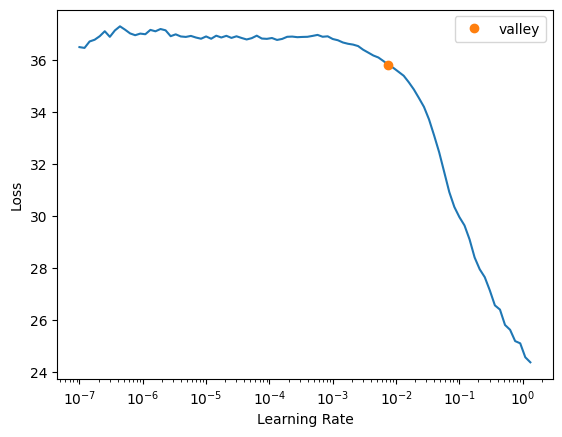

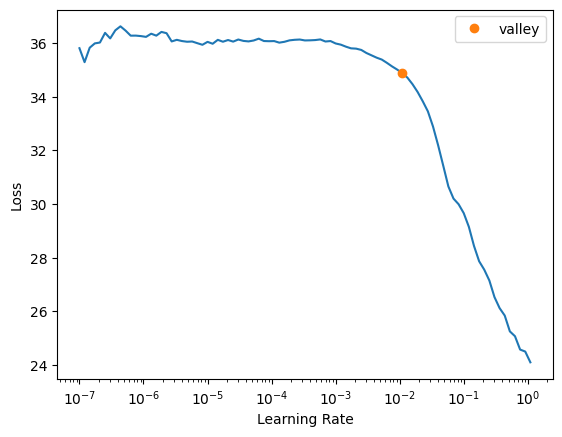

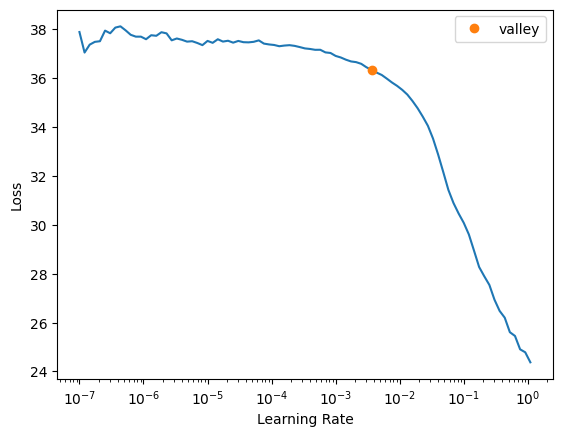

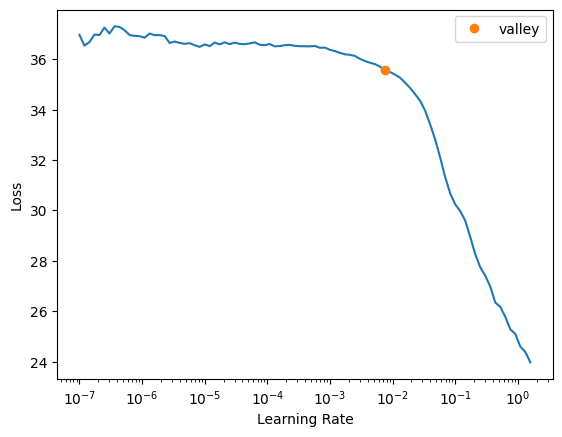

In [21]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAM'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][layer] = end-start


<Figure size 1200x600 with 0 Axes>

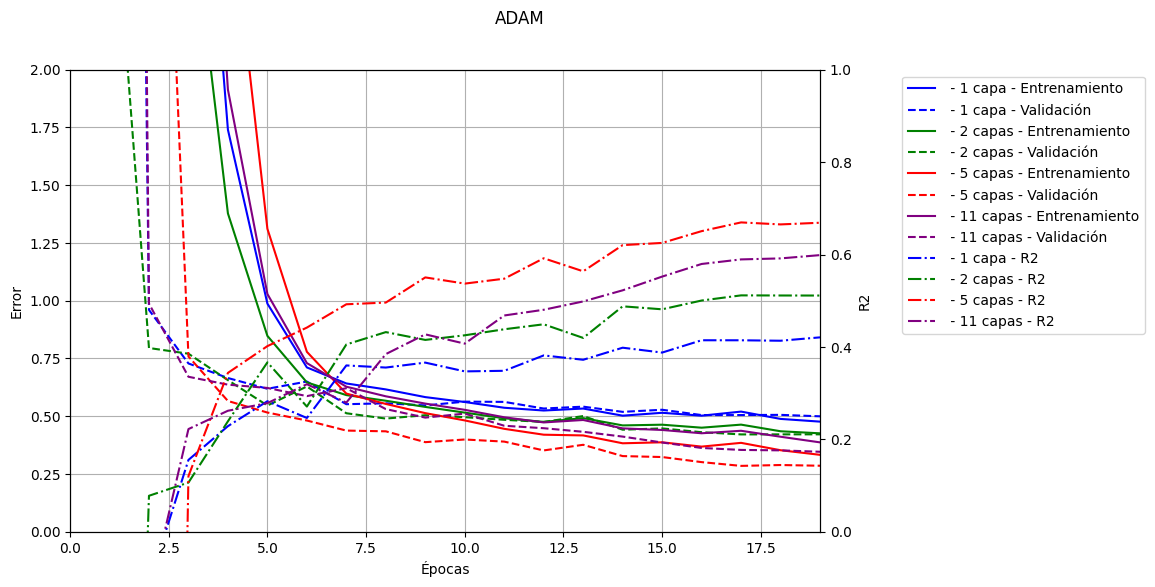

In [22]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title='ADAM', lim=2, names=names_layer, metric=metric)

### AdamW

Better model found at epoch 0 with valid_loss value: 29.199970245361328.
Better model found at epoch 1 with valid_loss value: 5.270117282867432.
Better model found at epoch 2 with valid_loss value: 0.705531895160675.
Better model found at epoch 3 with valid_loss value: 0.6796286702156067.
Better model found at epoch 5 with valid_loss value: 0.5714515447616577.
Better model found at epoch 7 with valid_loss value: 0.5558844208717346.
Better model found at epoch 8 with valid_loss value: 0.5449091792106628.
Better model found at epoch 9 with valid_loss value: 0.5358691811561584.
Better model found at epoch 14 with valid_loss value: 0.5253711938858032.
Better model found at epoch 16 with valid_loss value: 0.5134046673774719.
Better model found at epoch 17 with valid_loss value: 0.5086847543716431.
Better model found at epoch 18 with valid_loss value: 0.5083586573600769.
Better model found at epoch 19 with valid_loss value: 0.5070189237594604.


Better model found at epoch 0 with valid_loss value: 29.66143798828125.
Better model found at epoch 1 with valid_loss value: 3.0535242557525635.
Better model found at epoch 2 with valid_loss value: 0.7623318433761597.
Better model found at epoch 4 with valid_loss value: 0.6378272175788879.
Better model found at epoch 5 with valid_loss value: 0.5590418577194214.
Better model found at epoch 7 with valid_loss value: 0.5217192769050598.
Better model found at epoch 8 with valid_loss value: 0.4927646219730377.
Better model found at epoch 10 with valid_loss value: 0.4822413921356201.
Better model found at epoch 12 with valid_loss value: 0.47479623556137085.
Better model found at epoch 14 with valid_loss value: 0.4377460777759552.
Better model found at epoch 16 with valid_loss value: 0.4321781396865845.
Better model found at epoch 17 with valid_loss value: 0.4199925661087036.
Better model found at epoch 18 with valid_loss value: 0.4180199205875397.


Better model found at epoch 0 with valid_loss value: 31.523624420166016.
Better model found at epoch 1 with valid_loss value: 19.987953186035156.
Better model found at epoch 2 with valid_loss value: 1.1075303554534912.
Better model found at epoch 3 with valid_loss value: 0.6068103313446045.
Better model found at epoch 4 with valid_loss value: 0.5389089584350586.
Better model found at epoch 5 with valid_loss value: 0.47345978021621704.
Better model found at epoch 8 with valid_loss value: 0.43505826592445374.
Better model found at epoch 9 with valid_loss value: 0.4056563973426819.
Better model found at epoch 10 with valid_loss value: 0.39514756202697754.
Better model found at epoch 11 with valid_loss value: 0.3857679069042206.
Better model found at epoch 12 with valid_loss value: 0.36306920647621155.
Better model found at epoch 14 with valid_loss value: 0.337429404258728.
Better model found at epoch 15 with valid_loss value: 0.3183753490447998.
Better model found at epoch 16 with valid_l

Better model found at epoch 0 with valid_loss value: 32.665531158447266.
Better model found at epoch 1 with valid_loss value: 22.882539749145508.
Better model found at epoch 2 with valid_loss value: 1.0009846687316895.
Better model found at epoch 3 with valid_loss value: 0.5912987589836121.
Better model found at epoch 4 with valid_loss value: 0.5899462699890137.
Better model found at epoch 6 with valid_loss value: 0.5733957886695862.
Better model found at epoch 7 with valid_loss value: 0.5404025316238403.
Better model found at epoch 8 with valid_loss value: 0.5294155478477478.
Better model found at epoch 9 with valid_loss value: 0.49651002883911133.
Better model found at epoch 10 with valid_loss value: 0.4775242507457733.
Better model found at epoch 11 with valid_loss value: 0.4419691860675812.
Better model found at epoch 12 with valid_loss value: 0.43181416392326355.
Better model found at epoch 14 with valid_loss value: 0.4027152955532074.
Better model found at epoch 15 with valid_los

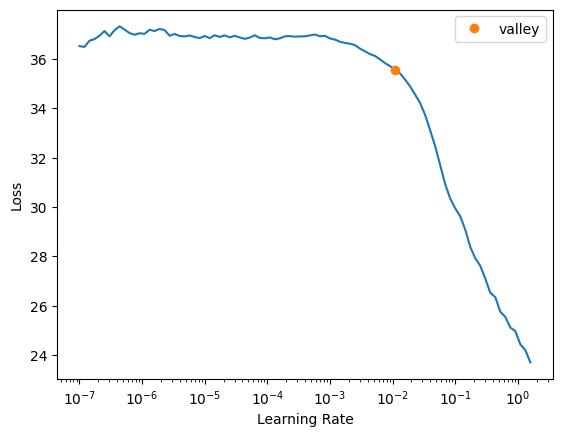

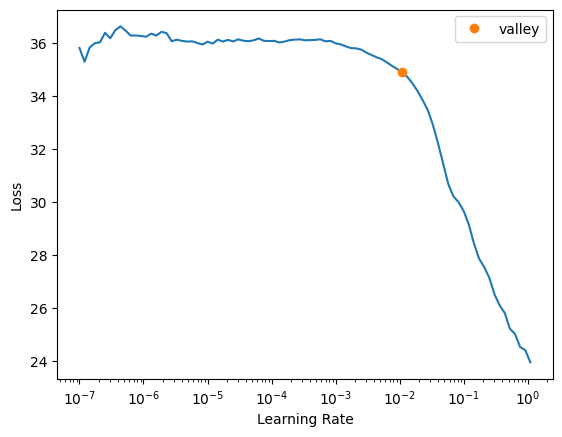

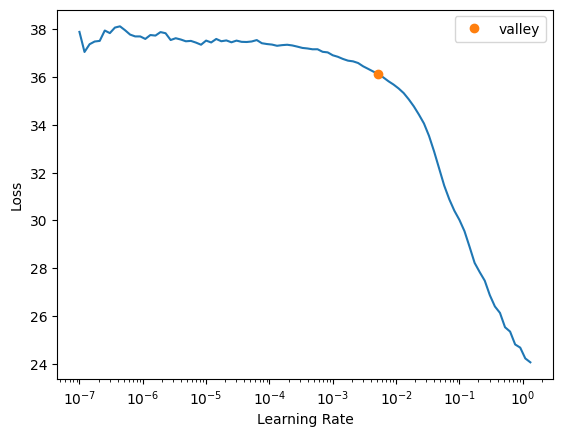

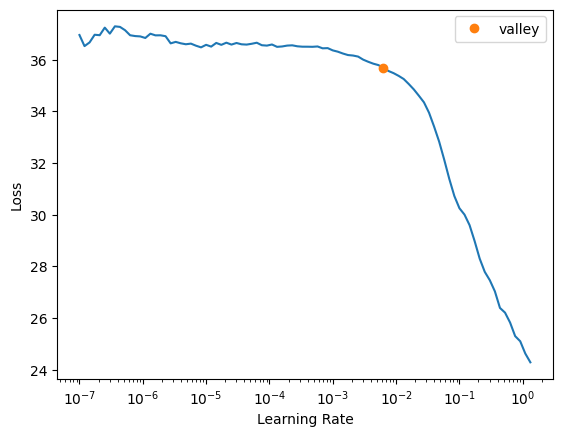

In [23]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAMW'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAMW'][layer] = end-start

<Figure size 1200x600 with 0 Axes>

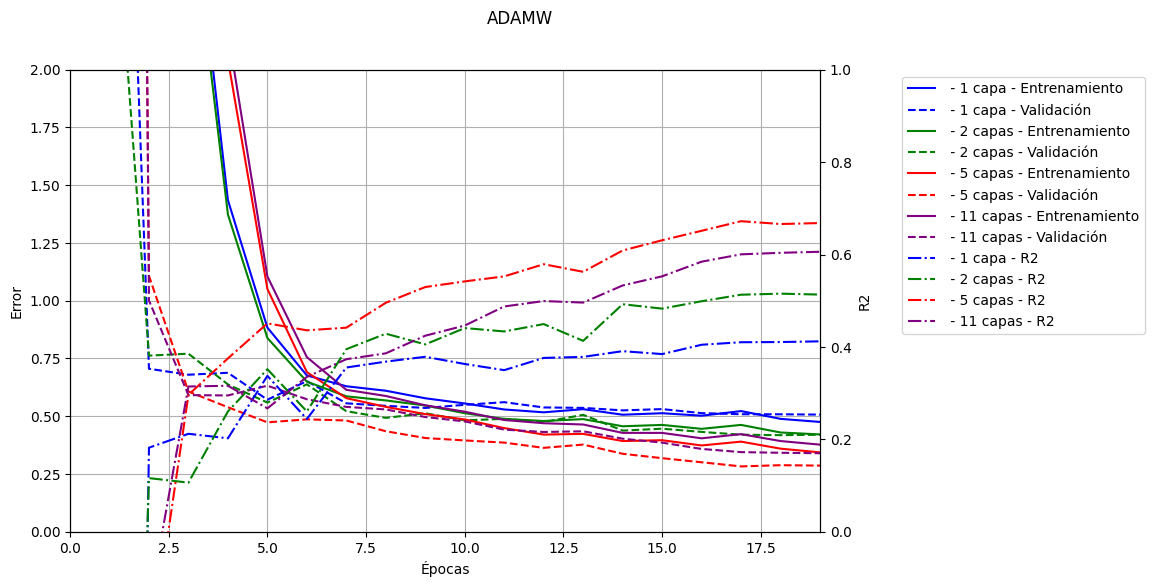

In [24]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAMW'].values(), title='ADAMW', lim=2, names=names_layer, metric=metric)

### Save or Load models

In [25]:
#Save learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][layer], 'recorder_values': learners[optim][layer].recorder.values}, f)
        
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_gd, f)


In [16]:
#Load learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][layer], learners[optim][layer].recorder.values = data['learner'], data['recorder_values']
    
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'rb') as f:
    time_gd = pickle.load(f)


### Comparative per layers

<Figure size 1200x600 with 0 Axes>

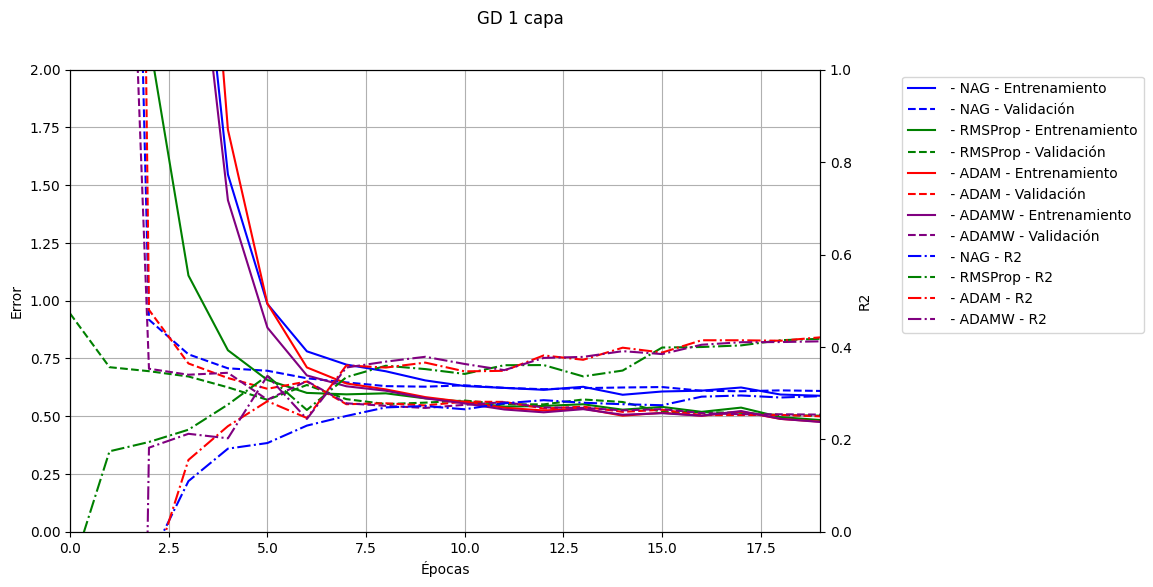

<Figure size 1200x600 with 0 Axes>

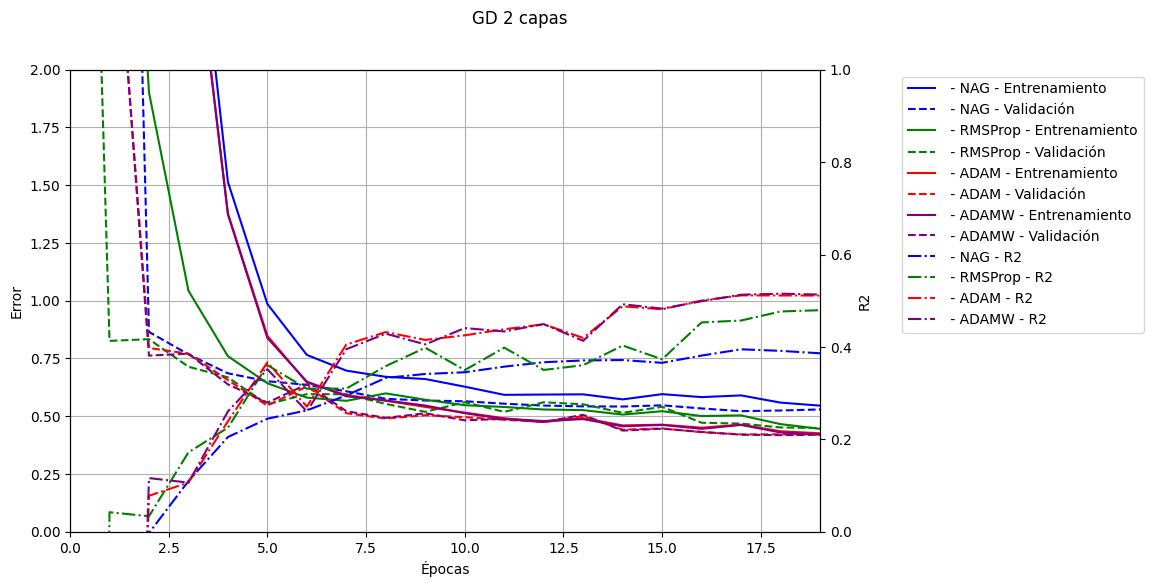

<Figure size 1200x600 with 0 Axes>

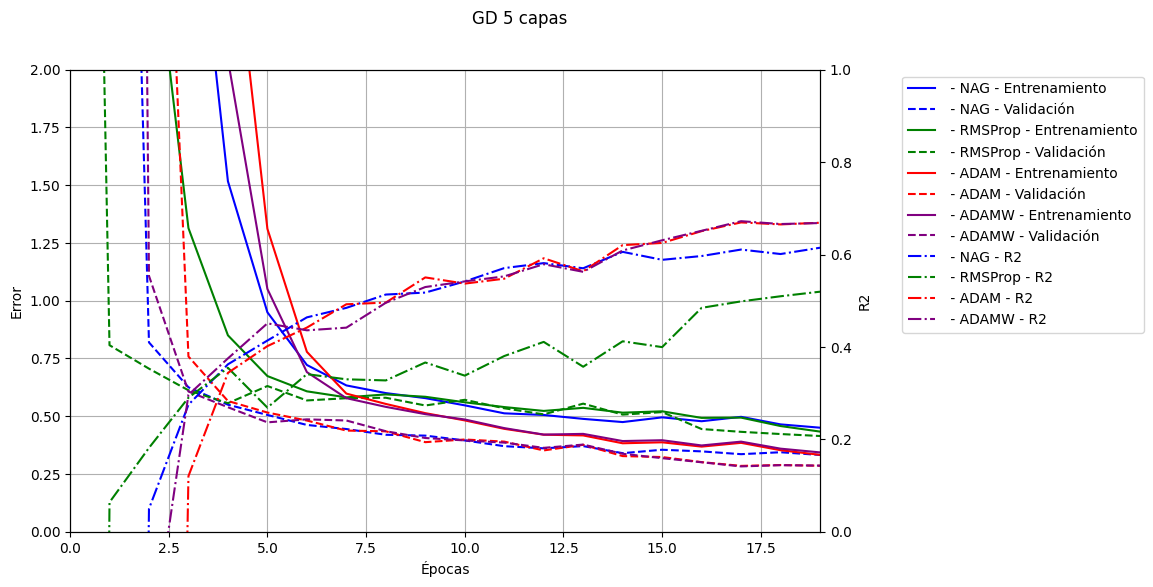

<Figure size 1200x600 with 0 Axes>

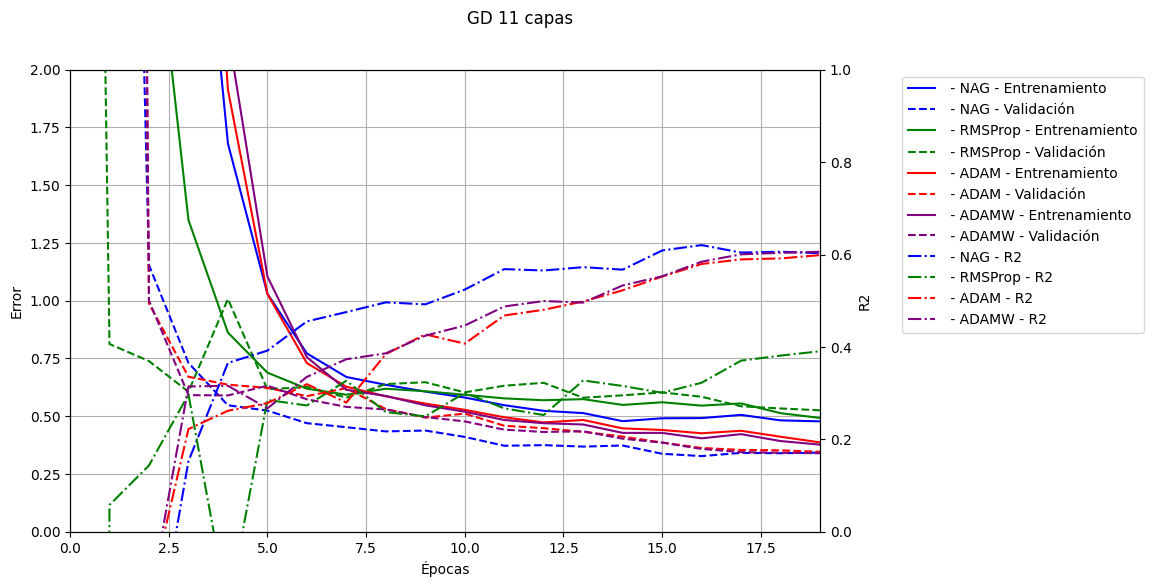

In [26]:
#Compare the three optimizers for each layer

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1], learners['ADAMW'][1]]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2], learners['ADAMW'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5], learners['ADAMW'][5]]
learners_11_layers = [learners['NAG'][11], learners['RMSProp'][11], learners['ADAM'][11], learners['ADAMW'][11]]

names=['NAG', 'RMSProp', 'ADAM', 'ADAMW']
utilsTFG.plot_learners_training(learners_1_layer, lim = 2, title='GD 1 capa', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_2_layers, lim = 2, title='GD 2 capas', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_5_layers, lim = 2, title='GD 5 capas', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_11_layers, lim = 2, title='GD 11 capas', names=names, metric=metric)

### Generalization

In [27]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()



    #Calculate Adjusted R2 Square

    r2 = utilsTFG.adjusted_r2_score(preds.squeeze(), targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test', task='reg')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Adjusted R2 Square: {r2}")

Optimizer: NAG, Layers: 1, Loss: 0.7780621647834778, Adjusted R2 Square: -0.07263493131368981


Optimizer: NAG, Layers: 2, Loss: 1.0424585342407227, Adjusted R2 Square: 0.03701856789634017


Optimizer: NAG, Layers: 5, Loss: 1.816269874572754, Adjusted R2 Square: 0.1555241733140903


Optimizer: NAG, Layers: 11, Loss: 2.1485936641693115, Adjusted R2 Square: 0.035308131612288185


Optimizer: RMSProp, Layers: 1, Loss: 0.8579127788543701, Adjusted R2 Square: -0.14689229773084245


Optimizer: RMSProp, Layers: 2, Loss: 1.318591594696045, Adjusted R2 Square: -0.03221892949311189


Optimizer: RMSProp, Layers: 5, Loss: 2.0859086513519287, Adjusted R2 Square: 0.10362600535292155


Optimizer: RMSProp, Layers: 11, Loss: 2.372386932373047, Adjusted R2 Square: -0.003893645240930388


Optimizer: ADAM, Layers: 1, Loss: 1.174900770187378, Adjusted R2 Square: 0.028084880533049916


Optimizer: ADAM, Layers: 2, Loss: 1.2601420879364014, Adjusted R2 Square: 0.1046263357642705


Optimizer: ADAM, Layers: 5, Loss: 1.6844302415847778, Adjusted R2 Square: 0.19296397741986404


Optimizer: ADAM, Layers: 11, Loss: 3.136127471923828, Adjusted R2 Square: 0.05445592530147436


Optimizer: ADAMW, Layers: 1, Loss: 0.9717167615890503, Adjusted R2 Square: -0.01241304524307818


Optimizer: ADAMW, Layers: 2, Loss: 1.1258060932159424, Adjusted R2 Square: 0.07164697589876867


Optimizer: ADAMW, Layers: 5, Loss: 1.1798192262649536, Adjusted R2 Square: 0.23551929770548596


Optimizer: ADAMW, Layers: 11, Loss: 2.1622700691223145, Adjusted R2 Square: 0.1328895051279564


## Metaheuristics

In [28]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}
utilsTFG.set_seed()

#Initialise the population to have the same values for all the MH
for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  fitness[n_layer] = []
  optim=ADAM
  mh_learners[n_layer] = tabular_learner(dls, loss_func=MSELossFlat(), opt_func=ADAM, metrics=utilsTFG.AdjustedR2Score ,layers=layer, cbs=[SaveModelCallback()])
  mh_learners[n_layer].to(device)
  mh_learners[n_layer].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    #population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

    #fitness[n_layer].append(utilsTFG.err_param_w_model(model_copy, dls, task='reg'))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


In [26]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(population, f)
    
file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(fitness, f)


In [29]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'rb') as f:
    population = pickle.load(f)

file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'rb') as f:
    fitness = pickle.load(f)

In [29]:
for alg in algs:
    file_path = f'/notebooks/saved_models/{alg}_dict_{dataset}.pkl'
    with open(file_path, 'rb') as f:
        results[alg] = pickle.load(f)
    file_path = f'/notebooks/saved_models/{alg}_time_{dataset}.pkl'
    with open(file_path, 'rb') as f:
        time_mh[alg] = pickle.load(f)

In [17]:
time_full_mh = {}
for alg in ['SHADE', 'SHADE-ILS']:
    time_full_mh[alg]= time_mh[alg]

### Genetic Algorithms

In [26]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [30]:
#Runing SHADE algorithm

results['SHADE'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), pop_size,max_evals, len(population[layer][0]), dls,  model=mh_learners[layer].model, task='reg')
  end = time.perf_counter()
  time_mh['SHADE'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'], f)

file_path = f'/notebooks/saved_models/SHADE_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE'], f)


In [31]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  fitness_valid['SHADE'][layer] = []
  start = time.perf_counter()
  for ind in results['SHADE'][layer][5]:
    fitness_valid['SHADE'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))
  end = time.perf_counter()
  #time_full_mh['SHADE'][layer] += end - start 

In [32]:
#compare train and valid and select the best generalizing model.
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][6]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = np.array(fitness_valid['SHADE'][layer]) - np.array(results['SHADE'][layer][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][layer])
  best['SHADE'][layer] = results['SHADE'][layer][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for 1 layers: [35.83933639526367, 35.7375373840332, 35.35298156738281, 34.931453704833984, 34.931453704833984, 34.931453704833984, 34.931453704833984, 34.931453704833984, 34.931453704833984, 34.87052536010742, 34.87052536010742, 34.87052536010742, 34.87052536010742, 34.8576774597168, 34.8576774597168, 34.8576774597168, 34.8576774597168, 34.8576774597168, 34.8576774597168, 34.8576774597168, 34.79179000854492, 34.79179000854492, 34.79179000854492, 34.79179000854492, 34.79179000854492, 34.79179000854492, 34.79033279418945, 34.79033279418945, 34.74567413330078, 34.74567413330078, 34.67109680175781, 34.67109680175781, 34.67109680175781, 34.67109680175781, 34.67109680175781, 34.67109680175781, 34.67109680175781, 34.67109680175781, 34.67109680175781, 34.64453125, 34.64453125, 34.64453125, 34.64453125, 34.490440368652344, 34.490440368652344, 34.490440368652344, 34.490440368652344, 34.490440368652344, 34.490440368652344, 34.490440368652344, 34.490440368652344, 34.4904403

In [33]:
#Modify the shade lenght to adjust the others algorithms. I have selected the best before so we cant lose it.
for layer in n_layers:
    # Convert the tuple to a list
    shade_list = list(results['SHADE'][layer])
    
    # Modify the list
    shade_list[6] = [np.mean(shade_list[6][i:i+5]) for i in range(0, len(shade_list[6]), 5)]
    
    # Convert the list back to a tuple and assign it back to results['SHADE'][layer]
    results['SHADE'][layer] = tuple(shade_list)
    
    
    
    fitness_valid['SHADE'][layer] = [np.mean(fitness_valid['SHADE'][layer][i:i+5]) for i in range(0, len(fitness_valid['SHADE'][layer]), 5)]

### SHADE-ILS

In [31]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-ILS'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'], f)

file_path = f'/notebooks/saved_models/SHADE-ILS_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS'], f)


deque([1, 1, 0.9829586849274199], maxlen=3)
250
deque([1, 0.9829586849274199, 0.008891957635037707], maxlen=3)
458
deque([0.9829586849274199, 0.008891957635037707, -0.030087847427842988], maxlen=3)
669
deque([0.008891957635037707, -0.030087847427842988, -0.013062366834300072], maxlen=3)
Reiniciado
893
deque([1, 1, 0.7026125230604886], maxlen=3)
1109
deque([1, 0.7026125230604886, 0.05974351088091351], maxlen=3)
1334
deque([0.7026125230604886, 0.05974351088091351, 0.038140833068173084], maxlen=3)
1552
deque([0.05974351088091351, 0.038140833068173084, -0.035158189366359956], maxlen=3)
1781
deque([0.038140833068173084, -0.035158189366359956, 0.03127989647470487], maxlen=3)
Reiniciado
2006
deque([1, 1, 0.5288561618814508], maxlen=3)
2221
deque([1, 0.5288561618814508, 0.026971319371048616], maxlen=3)
2432
deque([0.5288561618814508, 0.026971319371048616, 0.008349909480529771], maxlen=3)
2645
deque([0.026971319371048616, 0.008349909480529771, 0.07800558747542108], maxlen=3)
2860
deque([0.00834

In [34]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  start = time.perf_counter()
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))
  end = time.perf_counter()
  #time_full_mh['SHADE-ILS'][layer]+= end-start

In [35]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-ILS'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][layer])
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for 1 layers: [35.83933639526367, 0.6107494235038757, 0.6053186655044556, 0.6053186655044556, 0.6053186655044556, 0.6053186655044556, 0.5883806347846985, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296, 0.5659393072128296]
Validation error of SHADE-ILS for 1 layers: [38.9868278503418, 0.7085713148117065, 0.7085713148117065, 0.7085713148117065, 0.7085713148117065, 0.7085713148117065, 0.7551991939544678, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212, 0.7502159476280212]
Difference: [3.14749146 0.09782189 0.10325265 0.10325265 0.10325265 0.10325

### SHADE-GD

deque([1, 1, 0.025332017323559268], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.2436656951904297.
deque([1, 0.025332017323559268, 0.6998515136554035], maxlen=3)
deque([0.025332017323559268, 0.6998515136554035, 0.8798775464520221], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7577149271965027.
deque([0.6998515136554035, 0.8798775464520221, 0.24429568297473048], maxlen=3)
deque([0.8798775464520221, 0.24429568297473048, 0.0587987665532498], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7106775045394897.
deque([0.24429568297473048, 0.0587987665532498, 0.1891646852806719], maxlen=3)
deque([0.0587987665532498, 0.1891646852806719, 0.045502006470006184], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6471072435379028.
deque([0.1891646852806719, 0.045502006470006184, 0.01851836727008963], maxlen=3)
deque([0.045502006470006184, 0.01851836727008963, 0.08214352442833593], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6560407876968384.
deque([0.01851836727008963, 0.08214352442833593, 0.0], maxlen=3)
deque([0.08214352442833593, 0.0, 0.004004705669927622], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6325196623802185.
deque([0.0, 0.004004705669927622, 0.0], maxlen=3)
Reiniciado
deque([1, 1, 0.44808672731478644], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7558925151824951.
deque([1, 0.44808672731478644, 0.4010075143237755], maxlen=3)
deque([0.44808672731478644, 0.4010075143237755, 0.05830411093656202], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7080520391464233.
deque([0.4010075143237755, 0.05830411093656202, 0.14468785876272883], maxlen=3)
deque([0.05830411093656202, 0.14468785876272883, 0.011380505317596575], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7342084050178528.
deque([0.14468785876272883, 0.011380505317596575, 0.0038406390581239257], maxlen=3)
deque([0.011380505317596575, 0.0038406390581239257, 0.03220033286786485], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.7422477006912231.
deque([1, 1, 0.607628766827724], maxlen=3)
deque([1, 0.607628766827724, 0.20893216356558622], maxlen=3)
deque([1, 1, 0.011266058045097867], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7796904444694519.
deque([1, 0.011266058045097867, 0.8186453314228687], maxlen=3)
deque([0.011266058045097867, 0.8186453314228687, 0.79187147416672], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6015371084213257.
deque([0.8186453314228687, 0.79187147416672, 0.5209158290181745], maxlen=3)
deque([0.79187147416672, 0.5209158290181745, 0.07493744081543552], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6284868717193604.
deque([0.5209158290181745, 0.07493744081543552, 0.020056969378427835], maxlen=3)
deque([0.07493744081543552, 0.020056969378427835, 0.025919085661886762], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6144534945487976.
deque([0.020056969378427835, 0.025919085661886762, 0.0], maxlen=3)
Reiniciado
deque([1, 1, 0.09822025611047544], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6978429555892944.
deque([1, 0.09822025611047544, 0.47442154772884443], maxlen=3)
deque([0.09822025611047544, 0.47442154772884443, 0.08790533099465533], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6413210034370422.
deque([0.47442154772884443, 0.08790533099465533, 0.10750086247270016], maxlen=3)
deque([0.08790533099465533, 0.10750086247270016, 0.02464415809370871], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6887502670288086.
deque([0.10750086247270016, 0.02464415809370871, 0.00035819301989140165], maxlen=3)
deque([0.02464415809370871, 0.00035819301989140165, 0.017436747483183856], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.668758749961853.
deque([1, 1, 0.43610286502379164], maxlen=3)
deque([1, 0.43610286502379164, 0.09424880070808826], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5896691083908081.
deque([0.43610286502379164, 0.09424880070808826, 0.1760441591530928], maxlen=3)
deque([0.09424880070808826, 0.1760441591530928, 0.0693998013851965], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5946934819221497.
deque([0.1760441591530928, 0.0693998013851965, 0.0], maxlen=3)
deque([0.0693998013851965, 0.0, 0.0326921154339507], maxlen=3)
deque([1, 1, 0.018439141349359145], maxlen=3)


/usr/local/lib/python3.11/dist-packages/fastai/callback/schedule.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


Better model found at epoch 0 with valid_loss value: 2.3397414684295654.
deque([1, 0.018439141349359145, 0.6668571161726923], maxlen=3)
deque([0.018439141349359145, 0.6668571161726923, 0.893098837383937], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6064220666885376.
deque([0.6668571161726923, 0.893098837383937, 0.48212099487956017], maxlen=3)
deque([0.893098837383937, 0.48212099487956017, 0.13075583013368122], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5722925066947937.
deque([0.48212099487956017, 0.13075583013368122, 0.0], maxlen=3)
deque([0.13075583013368122, 0.0, 0.028173663730883196], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.546156644821167.
deque([0.0, 0.028173663730883196, 0.057487611856403824], maxlen=3)
deque([0.028173663730883196, 0.057487611856403824, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5185269117355347.
deque([0.057487611856403824, 0.0, 0.10739632180044335], maxlen=3)
deque([0.0, 0.10739632180044335, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.4994572103023529.
deque([0.10739632180044335, 0.0, 0.08854447948438379], maxlen=3)
deque([0.0, 0.08854447948438379, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.49040454626083374.
deque([0.08854447948438379, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.6473469734191895.
deque([1, 1, 0.744130962699733], maxlen=3)
deque([1, 0.744130962699733, 0.17569055059048297], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5927000641822815.
deque([0.744130962699733, 0.17569055059048297, 0.30715486008637455], maxlen=3)
deque([0.17569055059048297, 0.30715486008637455, 0.03794601056157059], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5551025867462158.
deque([0.30715486008637455, 0.03794601056157059, 0.012028805082642197], maxlen=3)
deque([0.03794601056157059, 0.012028805082642197, 0.08517346553775512], maxlen=3)
deque([1, 1, 0.009180962328661701], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8120926022529602.
deque([1, 0.009180962328661701, 0.8273339924507717], maxlen=3)
deque([0.009180962328661701, 0.8273339924507717, 0.8537283658989958], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6750972270965576.
deque([0.8273339924507717, 0.8537283658989958, 0.296905704786796], maxlen=3)
deque([0.8537283658989958, 0.296905704786796, 0.03992986867863884], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6478934288024902.
deque([0.296905704786796, 0.03992986867863884, 0.05145967129130006], maxlen=3)
deque([0.03992986867863884, 0.05145967129130006, 0.004342768699561624], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6479172110557556.
deque([0.05145967129130006, 0.004342768699561624, 0.02645222100719927], maxlen=3)
deque([0.004342768699561624, 0.02645222100719927, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.6259584426879883.
deque([1, 1, 0.2413131730929051], maxlen=3)
deque([1, 0.2413131730929051, 0.05571370584122967], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6060084700584412.
deque([0.2413131730929051, 0.05571370584122967, 0.04228748916282728], maxlen=3)
deque([0.05571370584122967, 0.04228748916282728, 0.020966546176408342], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.609374463558197.
deque([0.04228748916282728, 0.020966546176408342, 0.034193892962293526], maxlen=3)
Reiniciado
deque([1, 1, 0.3668918922109003], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5990763306617737.
deque([1, 0.3668918922109003, 0.3582971034374584], maxlen=3)
deque([0.3668918922109003, 0.3582971034374584, 0.04009216795152244], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5496439337730408.
deque([0.3582971034374584, 0.04009216795152244, 0.061697287807244254], maxlen=3)
deque([0.04009216795152244, 0.061697287807244254, 0.03196807708225117], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6127020120620728.
deque([0.061697287807244254, 0.03196807708225117, 0.051378266143601636], maxlen=3)
deque([0.03196807708225117, 0.051378266143601636, 0.0], maxlen=3)


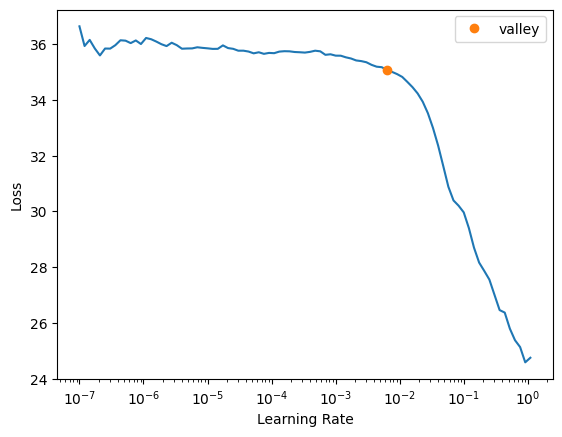

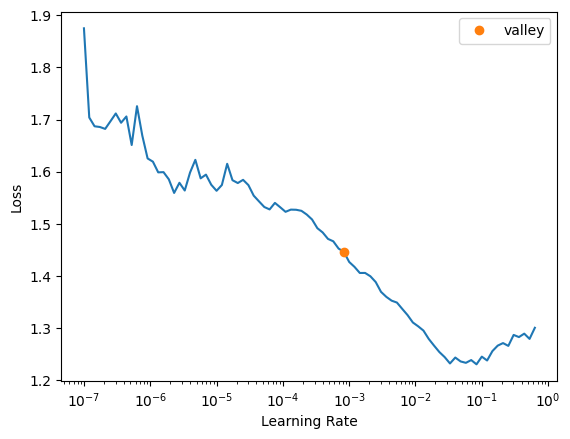

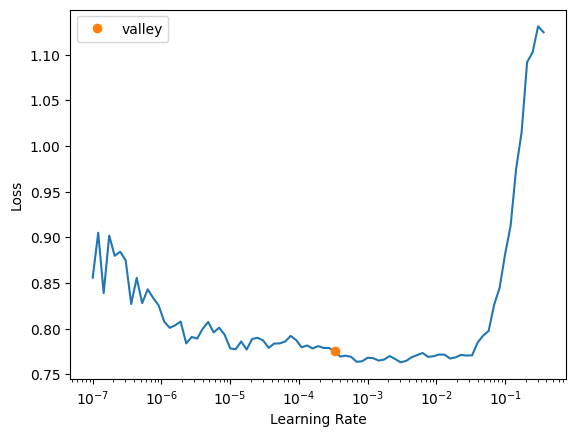

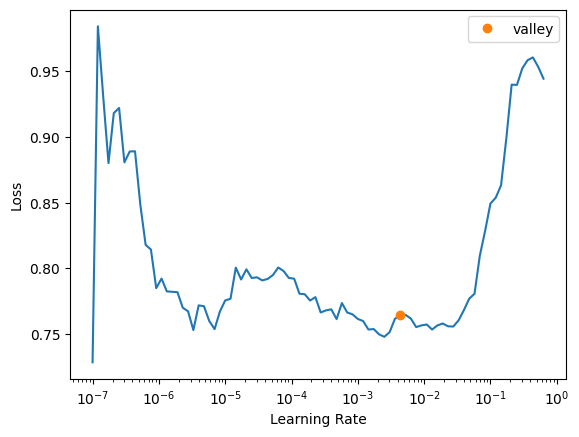

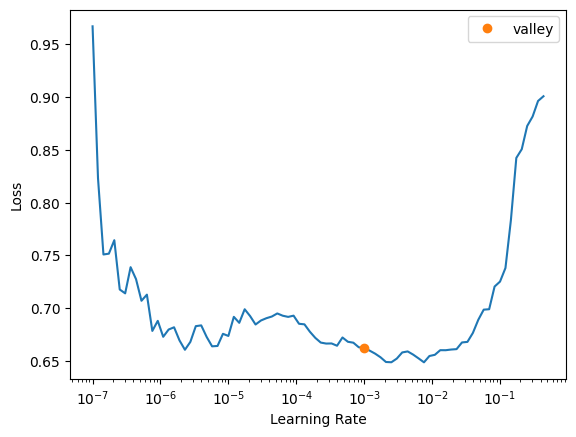

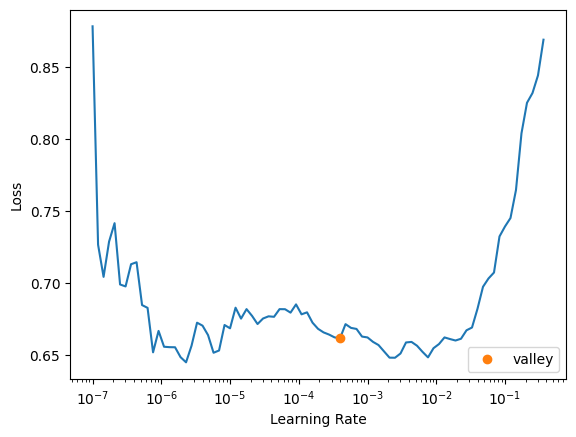

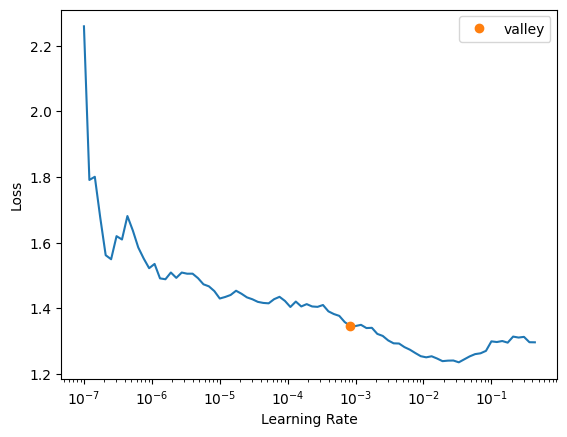

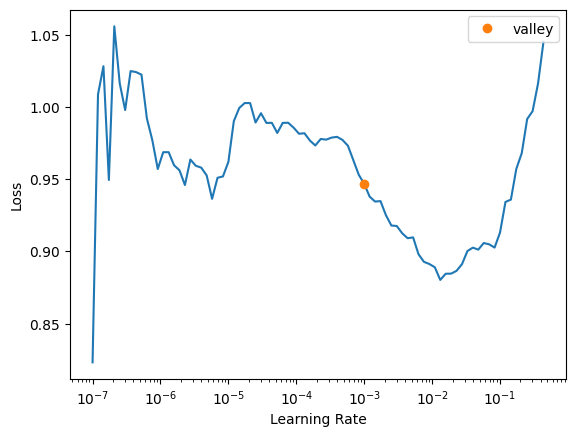

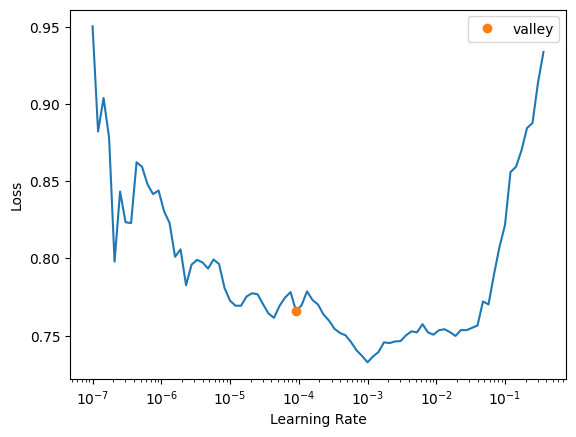

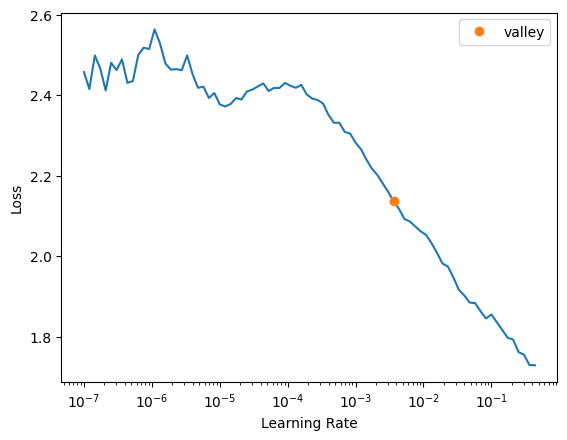

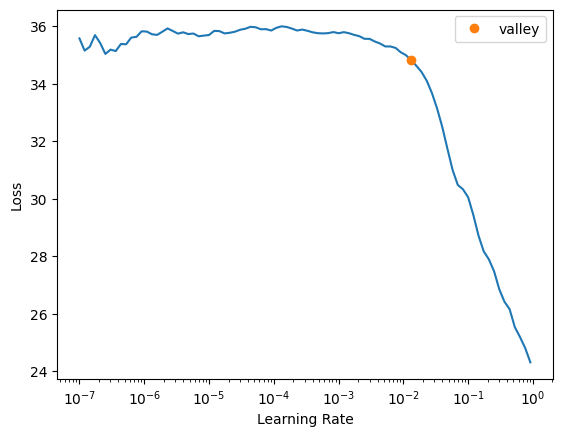

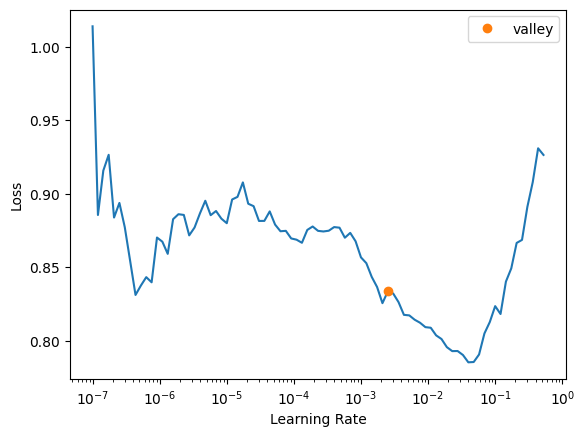

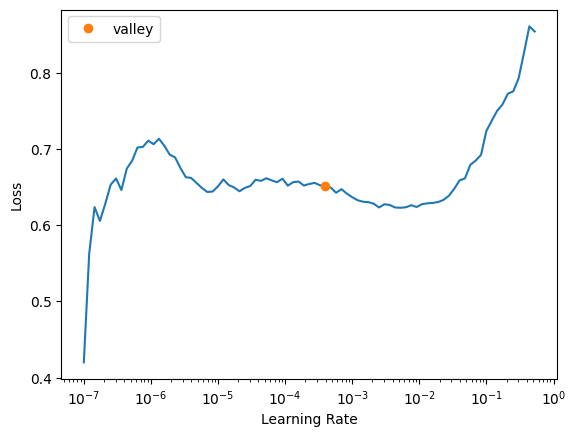

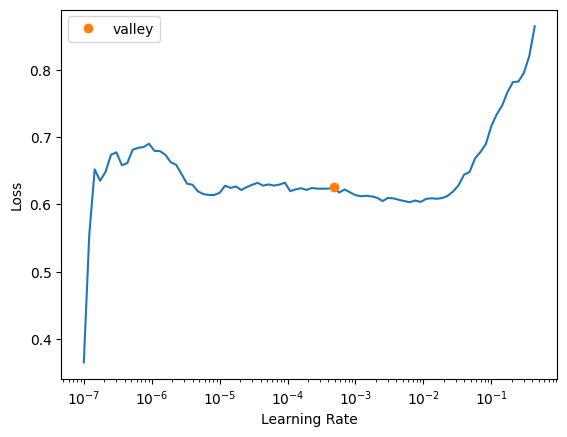

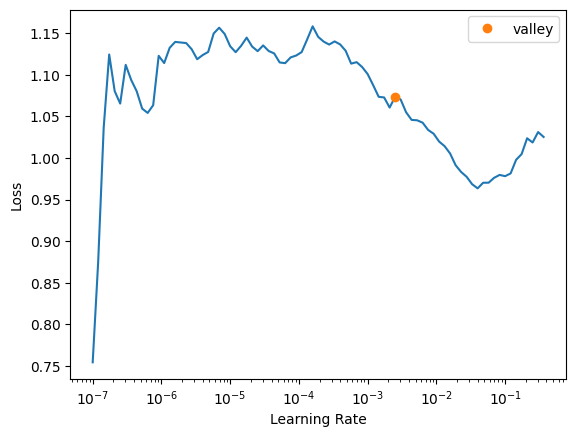

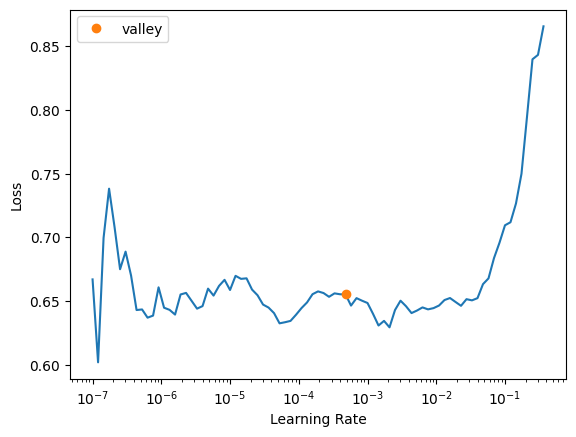

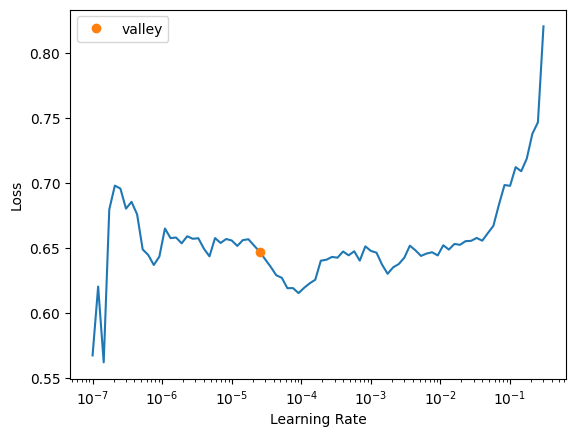

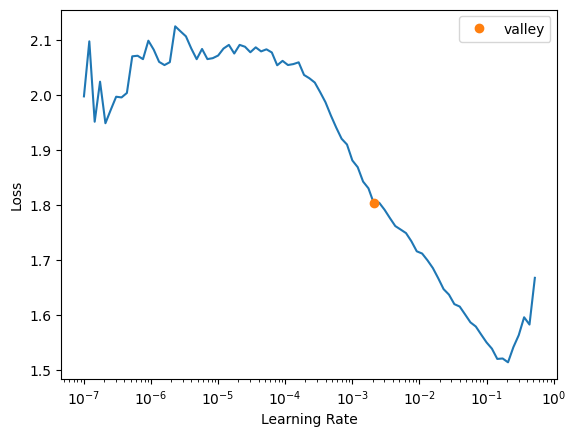

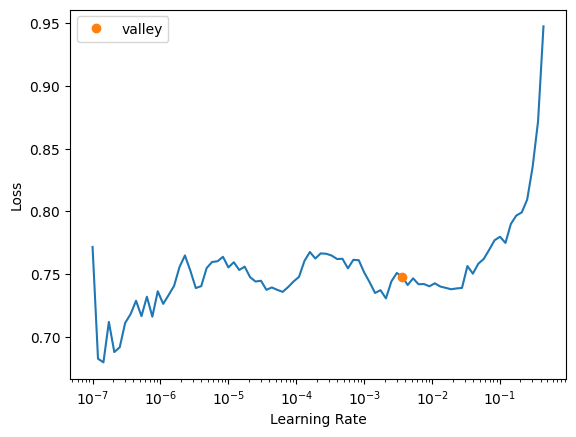

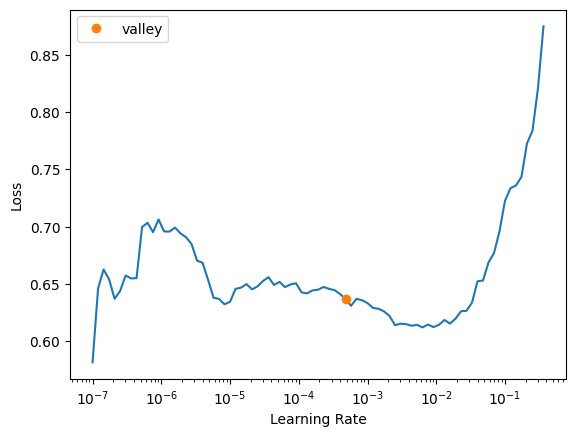

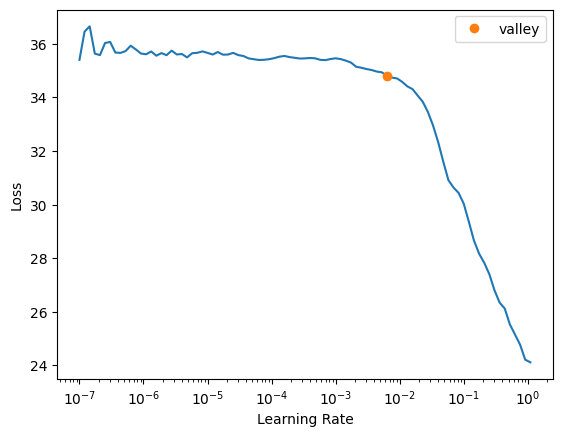

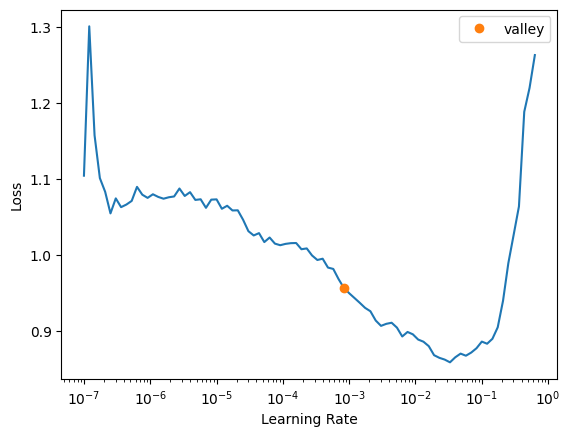

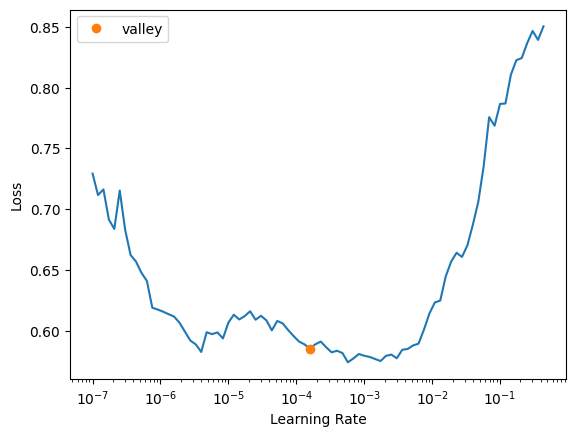

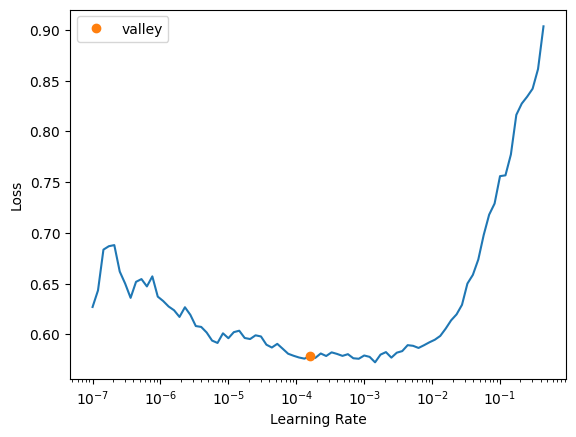

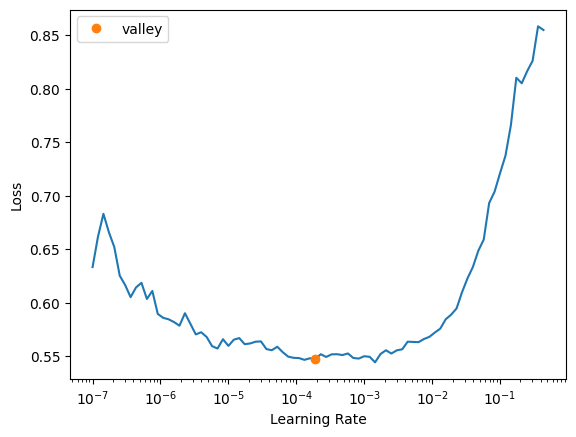

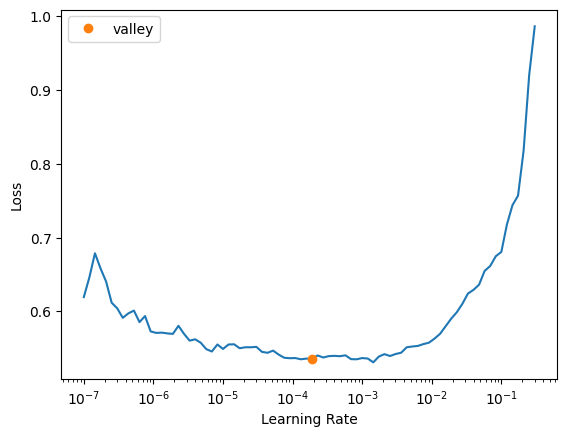

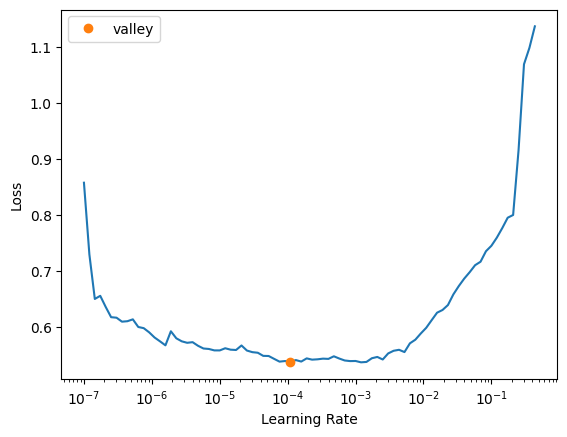

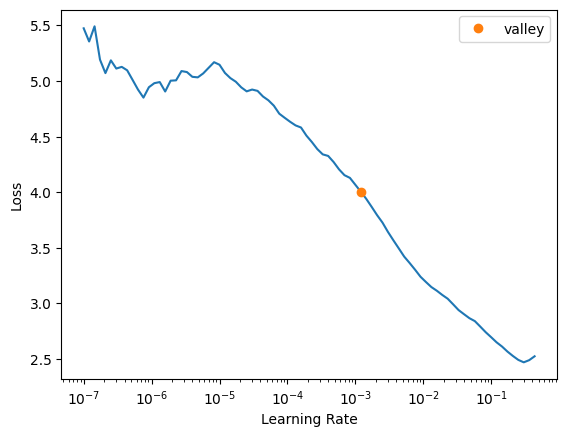

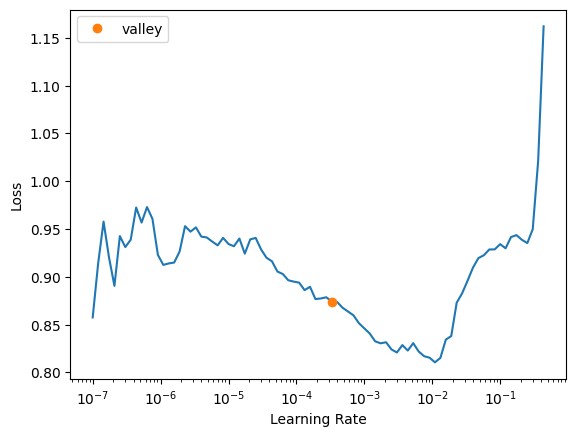

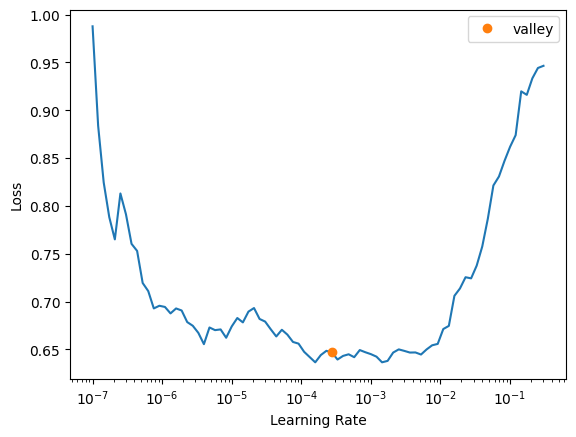

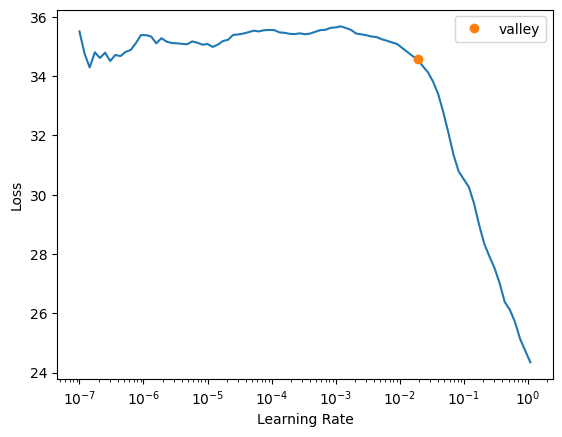

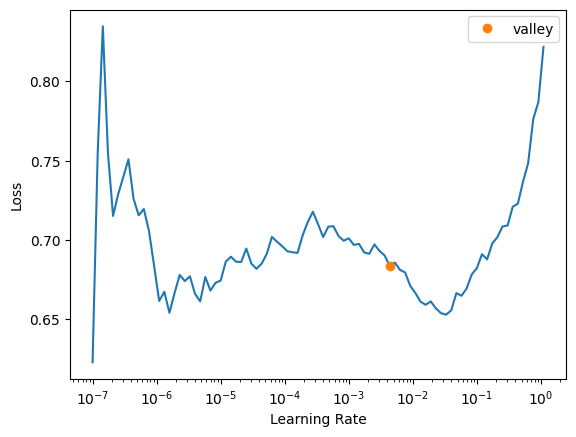

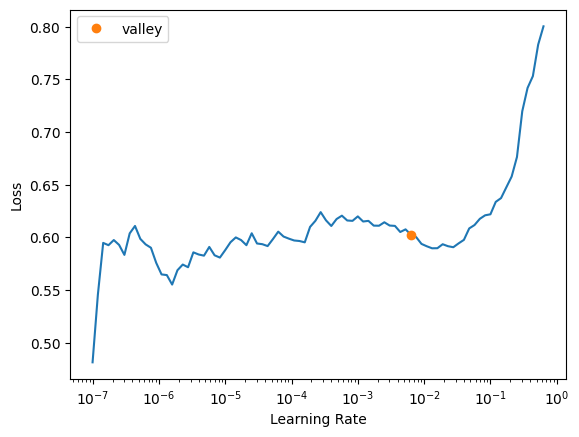

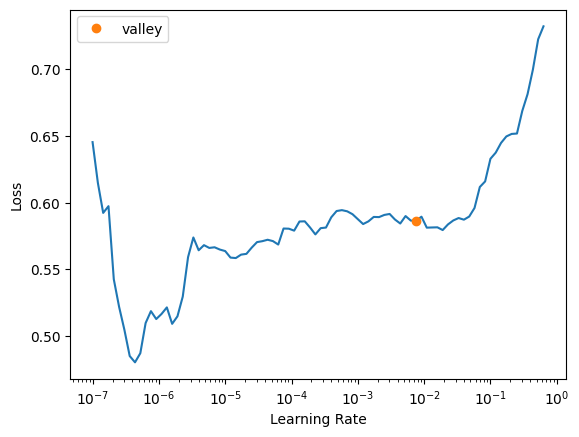

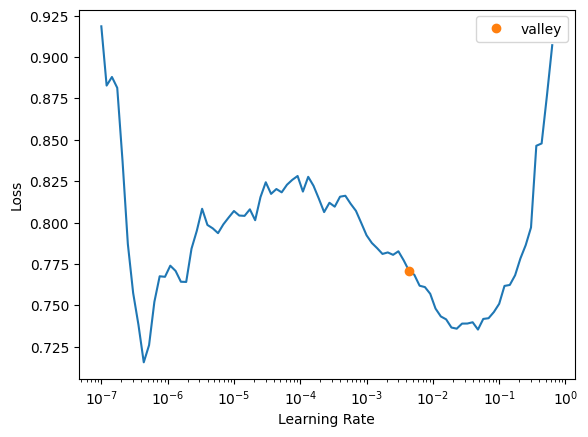

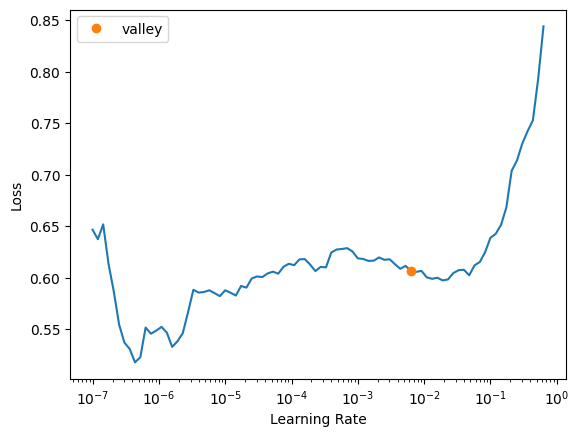

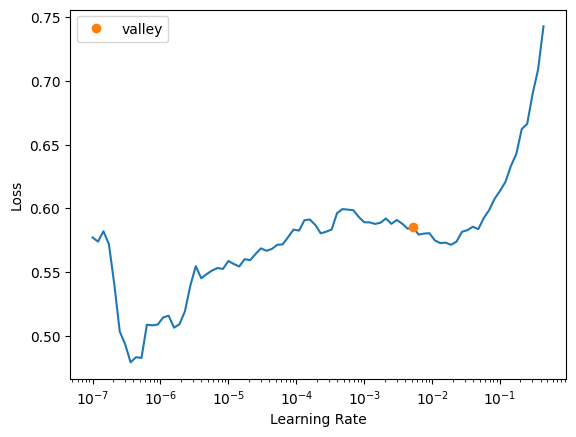

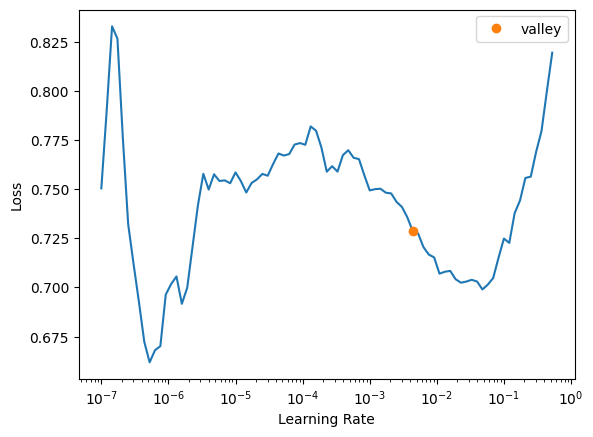

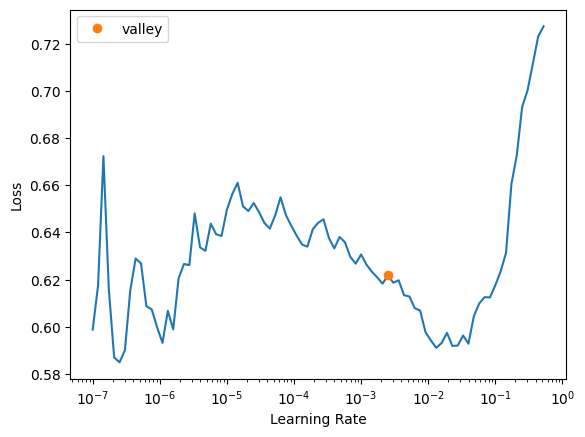

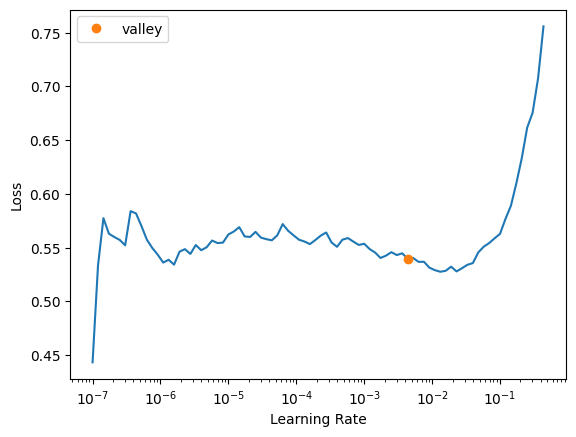

In [32]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-GD'][layer] = utilsTFG.SHADE_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-GD'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-GD'], f)

file_path = f'/notebooks/saved_models/SHADE-GD_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-GD'], f)


In [36]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [37]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-GD'][layer]) - np.array(results['SHADE-GD'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][layer])
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for 1 layers: [35.83933639526367, 34.931453704833984, 10.484622955322266, 1.2594386339187622, 0.9517632126808167, 0.8958007097244263, 0.7263468503952026, 0.6932966113090515, 0.6804578900337219, 0.624562680721283, 0.624562680721283, 0.6220614910125732, 0.6220614910125732, 0.6220614910125732, 0.6220614910125732, 0.6220614910125732, 0.6220614910125732, 0.6220614910125732, 0.6220614910125732, 0.6220614910125732, 0.6220614910125732, 0.6220614910125732]
Validation error of SHADE-GD for 1 layers: [38.9868278503418, 38.70869064331055, 1.1347923278808594, 0.8231547474861145, 0.7123421430587769, 0.7639636397361755, 0.7237043380737305, 0.7454054951667786, 0.7444930076599121, 0.7114970684051514, 0.7114970684051514, 0.7028019428253174, 0.7028019428253174, 0.7028019428253174, 0.7028019428253174, 0.7028019428253174, 0.7028019428253174, 0.7028019428253174, 0.7028019428253174, 0.7028019428253174, 0.7028019428253174, 0.7028019428253174]
Difference: [ 3.14749146e+00  3.77723694

### SHADE-ILS-GD

deque([1, 1, 0.9829586849274199], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6945627927780151.
deque([1, 0.9829586849274199, 0.008891957635037707], maxlen=3)
deque([0.9829586849274199, 0.008891957635037707, 0.010311393894301468], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6449570655822754.
deque([0.008891957635037707, 0.010311393894301468, 0.0], maxlen=3)
Reiniciado
deque([1, 1, 0.7652624985201472], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6425479650497437.
deque([1, 0.7652624985201472, 0.07760356691261414], maxlen=3)
deque([0.7652624985201472, 0.07760356691261414, -0.023891486492616736], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6579307317733765.
deque([0.07760356691261414, -0.023891486492616736, 0.007211082288695009], maxlen=3)
deque([-0.023891486492616736, 0.007211082288695009, -0.0004294867218996464], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.6233535408973694.
deque([1, 1, 0.744914585728749], maxlen=3)
deque([1, 0.744914585728749, 0.02954874383519897], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6469837427139282.
deque([0.744914585728749, 0.02954874383519897, 0.004291221751299212], maxlen=3)
deque([0.02954874383519897, 0.004291221751299212, 0.00042598352155147237], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.6503409743309021.
deque([1, 1, 0.7699731142082836], maxlen=3)
deque([1, 0.7699731142082836, 0.009039702459126662], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6505854725837708.
deque([0.7699731142082836, 0.009039702459126662, 0.019681998261102993], maxlen=3)
deque([0.009039702459126662, 0.019681998261102993, 0.1222215475793522], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6318889260292053.
deque([0.019681998261102993, 0.1222215475793522, -8.964044106455896e-05], maxlen=3)
deque([0.1222215475793522, -8.964044106455896e-05, 0.014415703765526663], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6274749636650085.
deque([-8.964044106455896e-05, 0.014415703765526663, -0.032798946674995694], maxlen=3)
Reiniciado
deque([1, 1, 0.983557156844861], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5844004154205322.
deque([1, 0.983557156844861, 0.006079561971875715], maxlen=3)
deque([0.983557156844861, 0.006079561971875715, 0.01940998686693162], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6546931862831116.
deque([0.006079561971875715, 0.01940998686693162, -0.005658825382250605], maxlen=3)
Reiniciado
deque([1, 1, 0.5745635418497095], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.658649206161499.
deque([1, 0.5745635418497095, 0.04922716576743262], maxlen=3)
deque([0.5745635418497095, 0.04922716576743262, 0.22440053854679542], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.599732518196106.
deque([0.04922716576743262, 0.22440053854679542, 0.05722013978171421], maxlen=3)
deque([0.22440053854679542, 0.05722013978171421, -0.07185455211188677], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5896081924438477.
deque([0.05722013978171421, -0.07185455211188677, 0.085973702247435], maxlen=3)
deque([-0.07185455211188677, 0.085973702247435, 0.00022732019570730592], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5768687725067139.
deque([0.085973702247435, 0.00022732019570730592, 0.00021848215421352578], maxlen=3)
deque([0.00022732019570730592, 0.00021848215421352578, 0.00021100617800098151], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.6245667934417725.
deque([1, 1, 0.59041182311241], maxlen=3)
deque([1, 0.59041182311241, -0.02168371232993674], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6127449870109558.
deque([0.59041182311241, -0.02168371232993674, 0.008902392590488008], maxlen=3)
deque([-0.02168371232993674, 0.008902392590488008, 0.10928153680155989], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5742788910865784.
deque([0.008902392590488008, 0.10928153680155989, 0.04906454582219474], maxlen=3)
deque([0.10928153680155989, 0.04906454582219474, -0.05978857018623203], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5504293441772461.
deque([0.04906454582219474, -0.05978857018623203, 0.09630735410120132], maxlen=3)
deque([1, 1, 0.9836499395066174], maxlen=3)


/usr/local/lib/python3.11/dist-packages/fastai/callback/schedule.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


Better model found at epoch 0 with valid_loss value: 0.5454158782958984.
deque([1, 0.9836499395066174, 0.002815974265023147], maxlen=3)
deque([0.9836499395066174, 0.002815974265023147, 0.017150544931755617], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5031050443649292.
deque([0.002815974265023147, 0.017150544931755617, 0.09156157676457939], maxlen=3)
deque([0.017150544931755617, 0.09156157676457939, 0.018186177457669293], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5469033718109131.
deque([0.09156157676457939, 0.018186177457669293, -0.06394909344756641], maxlen=3)
deque([0.018186177457669293, -0.06394909344756641, 0.029914989508662476], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.585211455821991.
deque([1, 1, 0.6785651430250452], maxlen=3)
deque([1, 0.6785651430250452, 0.05621836216958934], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5752223134040833.
deque([0.6785651430250452, 0.05621836216958934, -0.0041191719612458854], maxlen=3)
deque([0.05621836216958934, -0.0041191719612458854, 0.21779822961575787], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5481063723564148.
deque([-0.0041191719612458854, 0.21779822961575787, 0.1405099714632002], maxlen=3)
deque([0.21779822961575787, 0.1405099714632002, -0.16786637839335974], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5089145302772522.
deque([0.1405099714632002, -0.16786637839335974, 0.03301255201337191], maxlen=3)
deque([-0.16786637839335974, 0.03301255201337191, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.5231861472129822.
deque([1, 1, 0.6673175064555379], maxlen=3)
deque([1, 0.6673175064555379, 0.1554683763622539], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6415796279907227.
deque([0.6673175064555379, 0.1554683763622539, -0.015603948156423198], maxlen=3)
deque([0.1554683763622539, -0.015603948156423198, -0.015118415132531787], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6401415467262268.
deque([-0.015603948156423198, -0.015118415132531787, 0.03308204654383884], maxlen=3)
Reiniciado
deque([1, 1, 0.9832817729513443], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7245520949363708.
deque([1, 0.9832817729513443, 0.0327685317490198], maxlen=3)
deque([0.9832817729513443, 0.0327685317490198, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7080973386764526.
deque([0.0327685317490198, 0.0, 0.003682334374957049], maxlen=3)
Reiniciado
deque([1, 1, 0.2911998724523715], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6289008259773254.
deque([1, 0.2911998724523715, 0.12195923659386335], maxlen=3)
deque([0.2911998724523715, 0.12195923659386335, 0.05099891619435824], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6620615720748901.
deque([0.12195923659386335, 0.05099891619435824, 0.0], maxlen=3)
deque([0.05099891619435824, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6530128717422485.
deque([0.0, 0.0, 0.030710386459125154], maxlen=3)
Reiniciado
deque([1, 1, 0.48748642997986213], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6815795302391052.
deque([1, 0.48748642997986213, 0.1466338575127361], maxlen=3)
deque([0.48748642997986213, 0.1466338575127361, 0.015432656852481089], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6333547234535217.
deque([0.1466338575127361, 0.015432656852481089, 0.0509712265943293], maxlen=3)
deque([0.015432656852481089, 0.0509712265943293, 0.02668148235258391], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6498174071311951.
deque([0.0509712265943293, 0.02668148235258391, -0.020503712780712197], maxlen=3)
deque([0.02668148235258391, -0.020503712780712197, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.622435450553894.
deque([1, 1, 0.44450750964221325], maxlen=3)
deque([1, 0.44450750964221325, 0.06883220111641736], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6423618793487549.
deque([0.44450750964221325, 0.06883220111641736, -0.025106398146352335], maxlen=3)


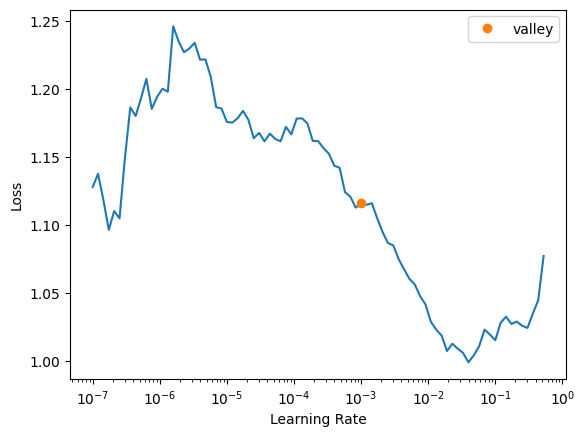

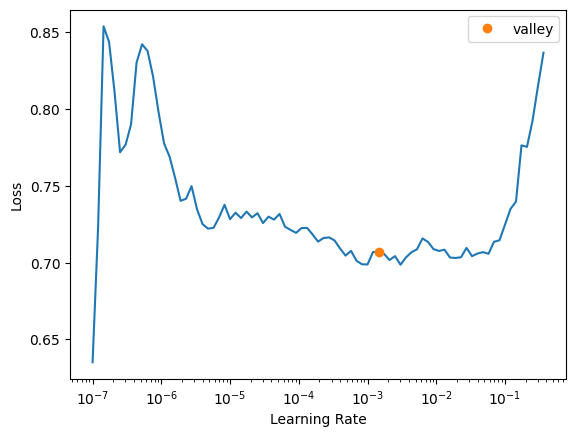

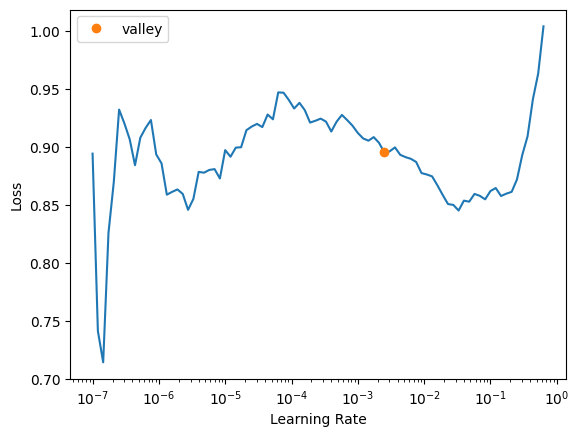

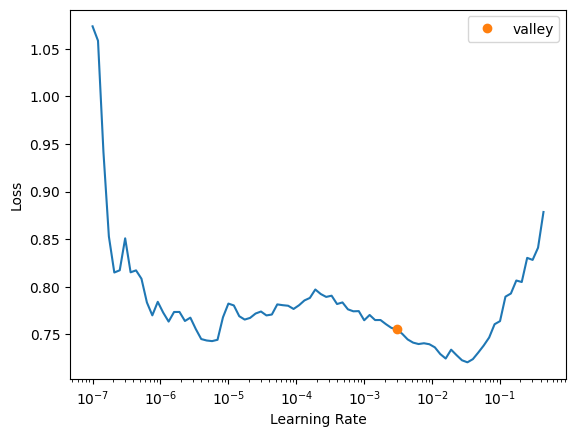

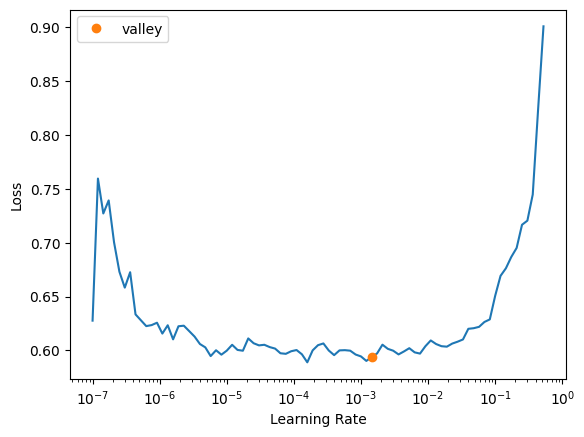

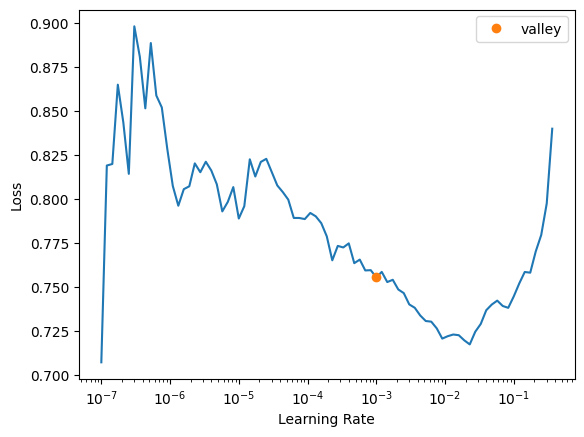

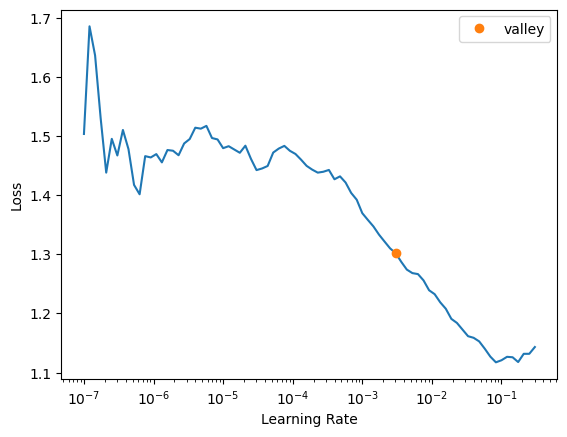

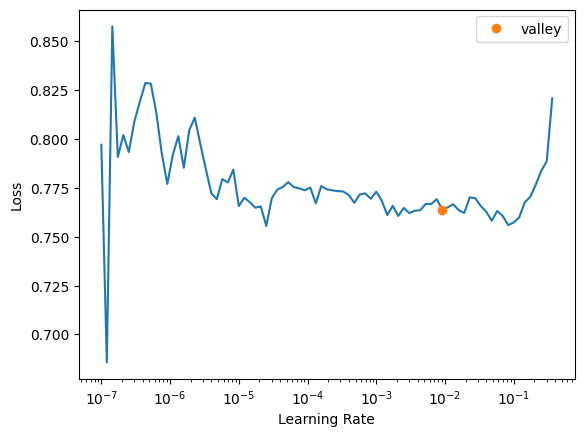

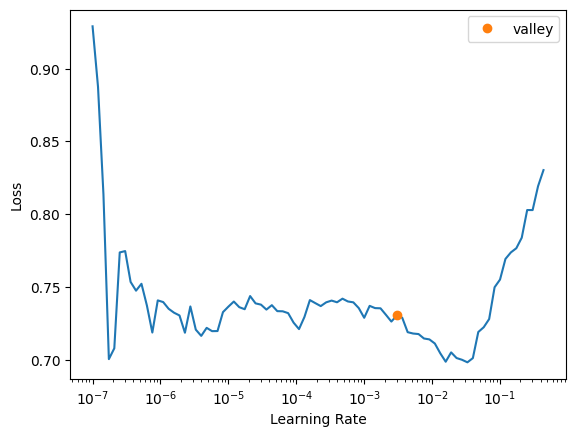

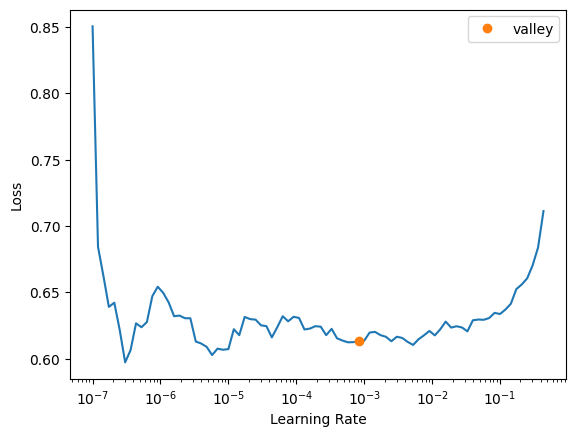

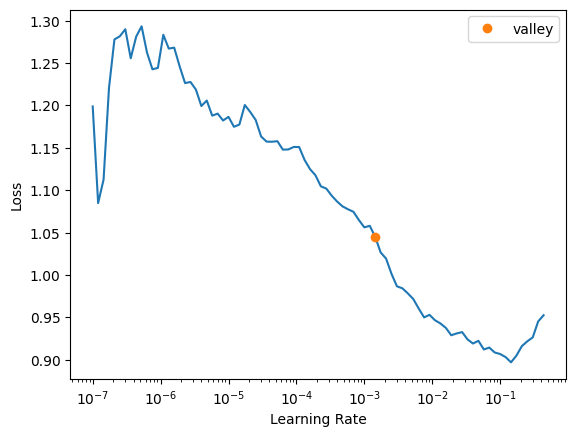

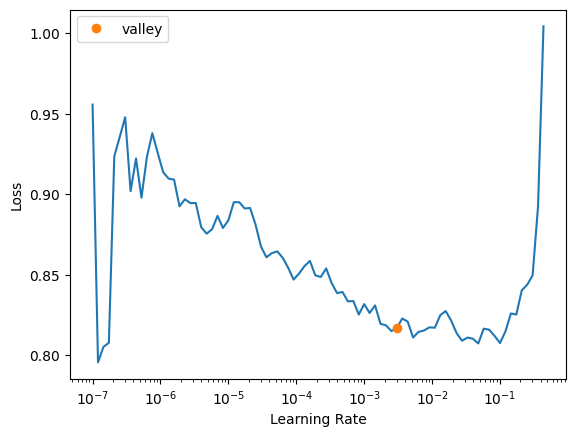

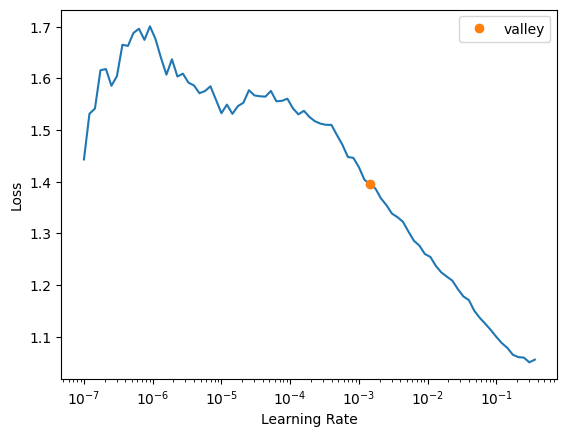

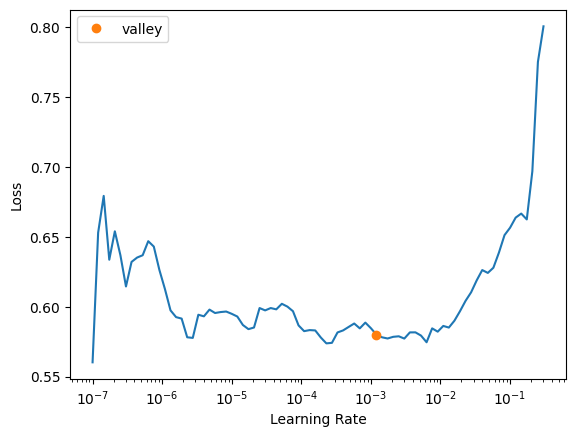

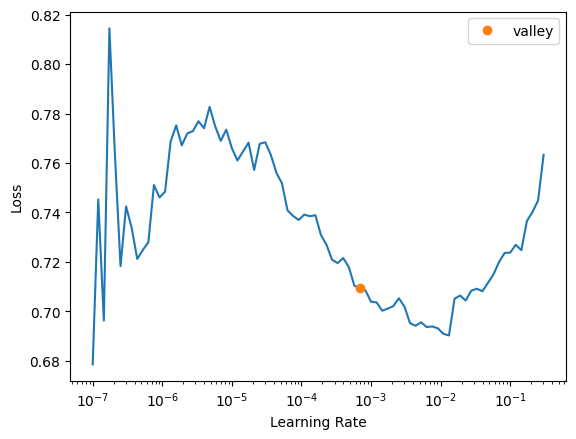

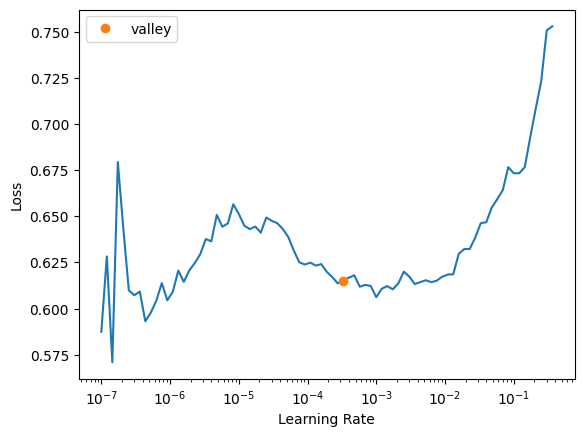

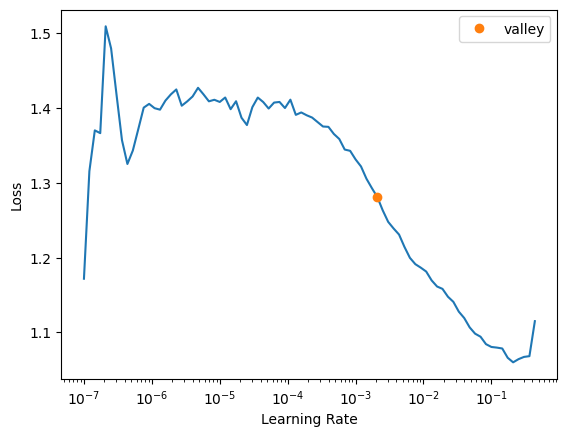

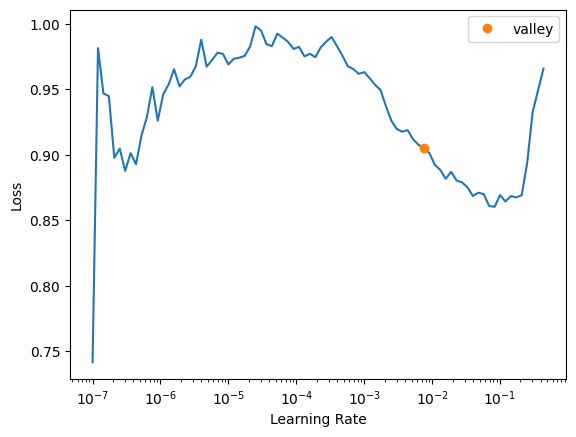

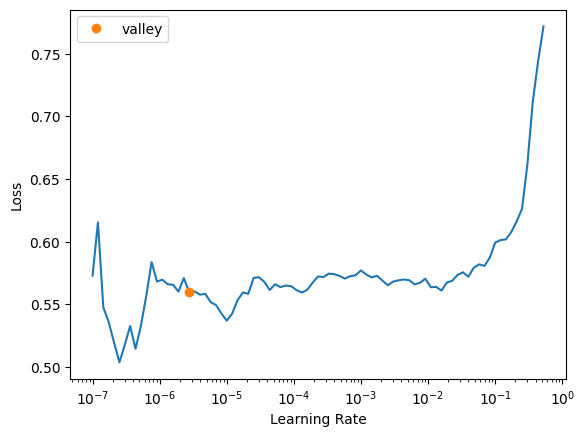

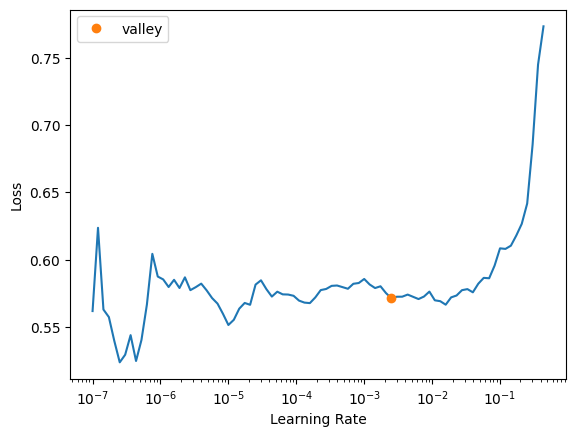

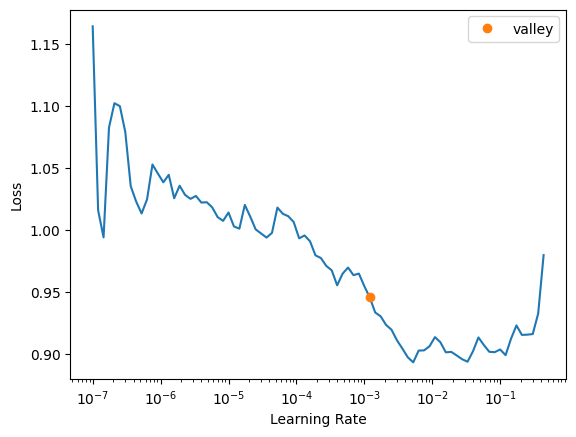

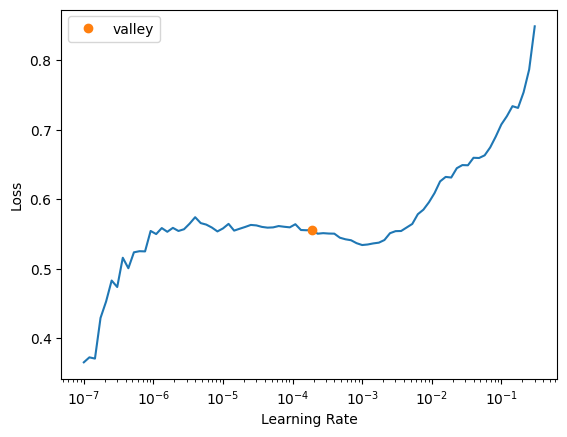

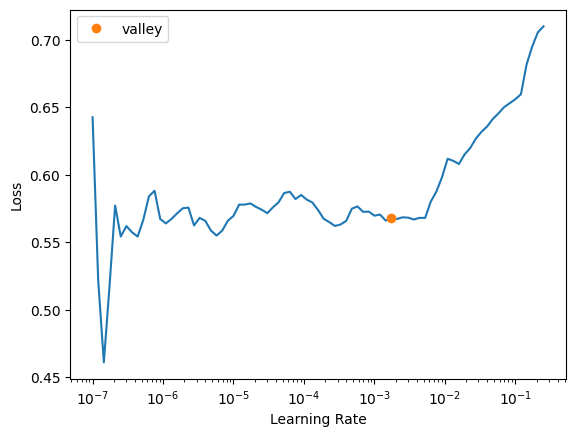

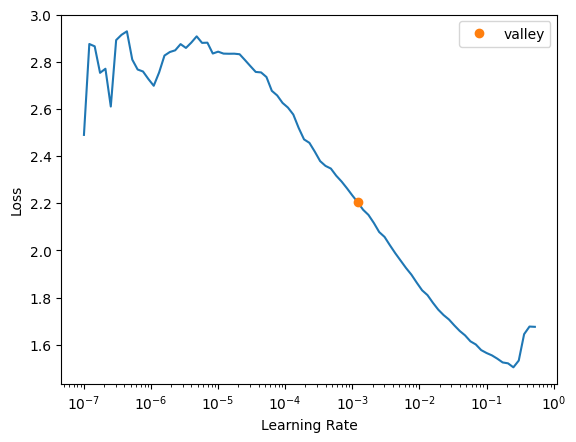

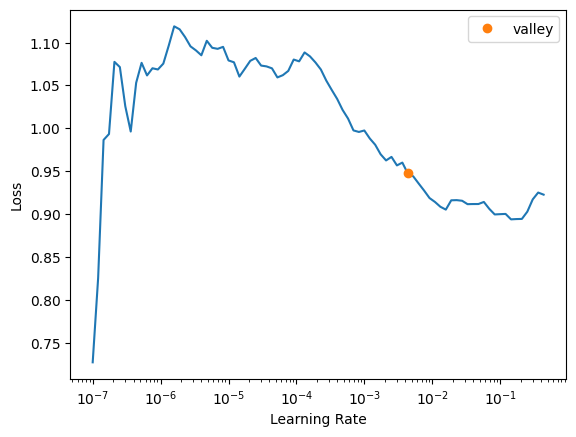

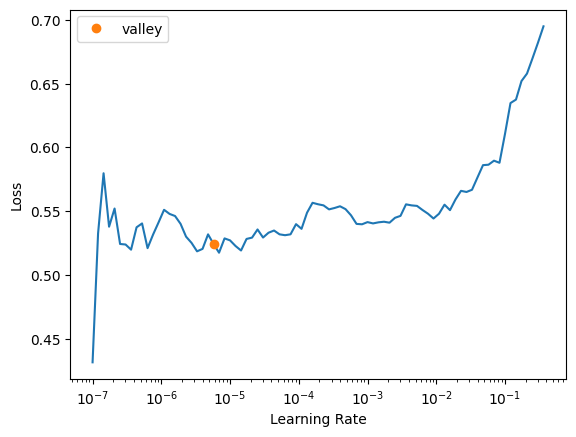

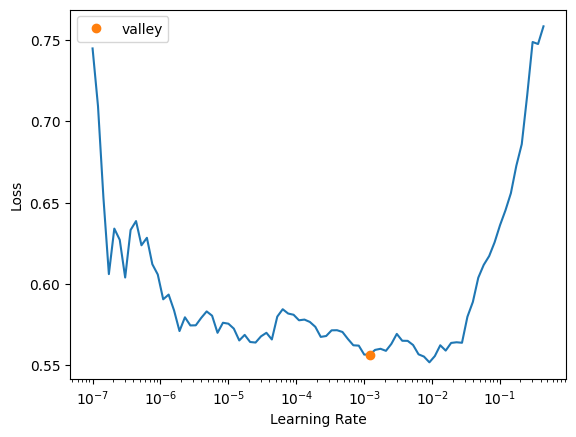

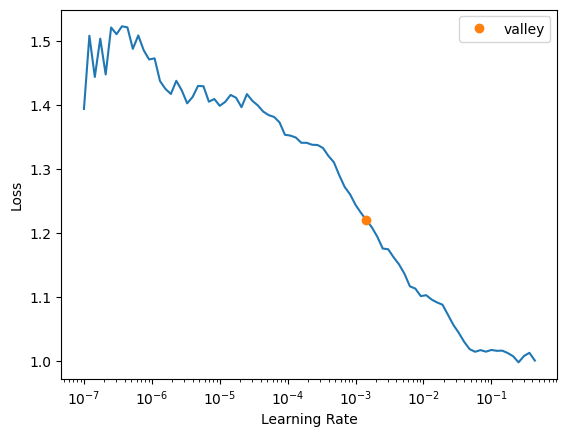

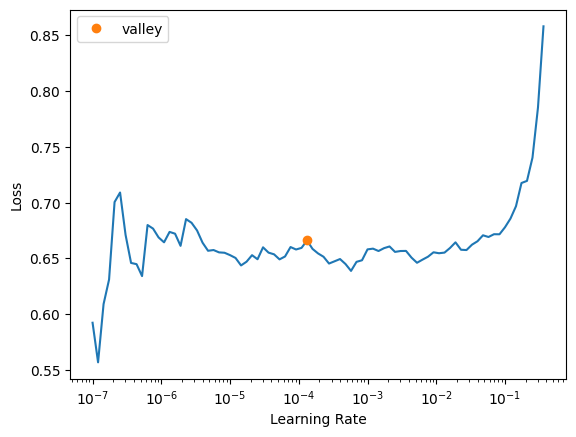

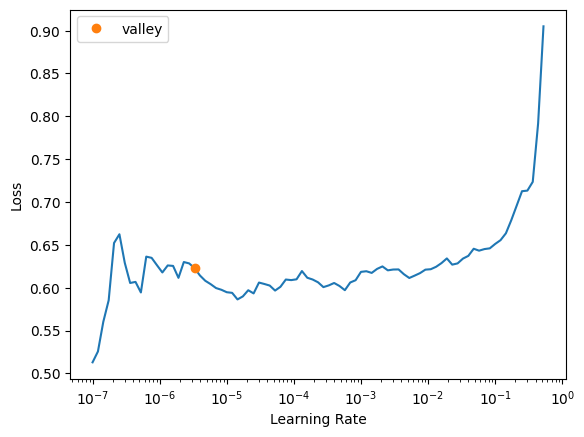

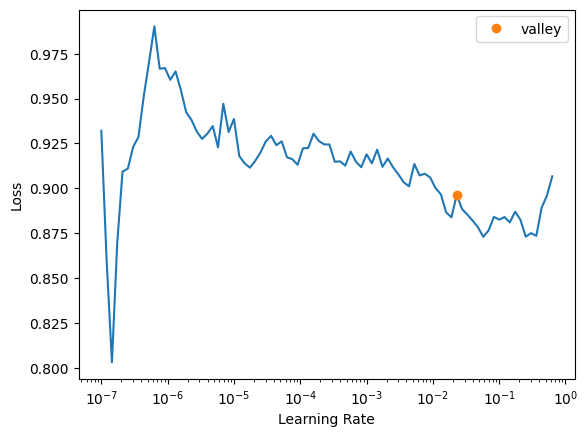

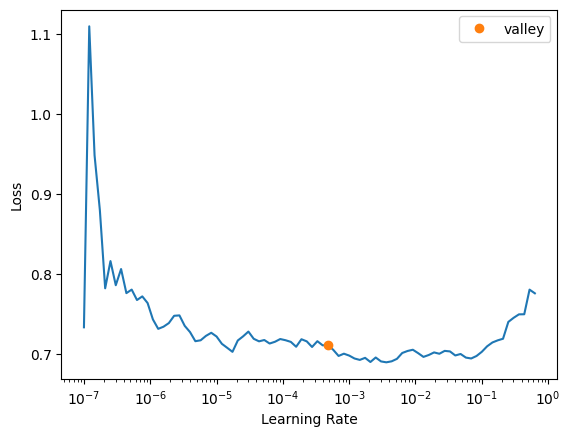

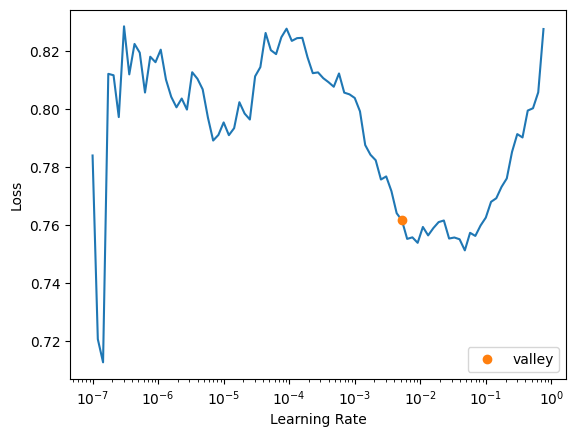

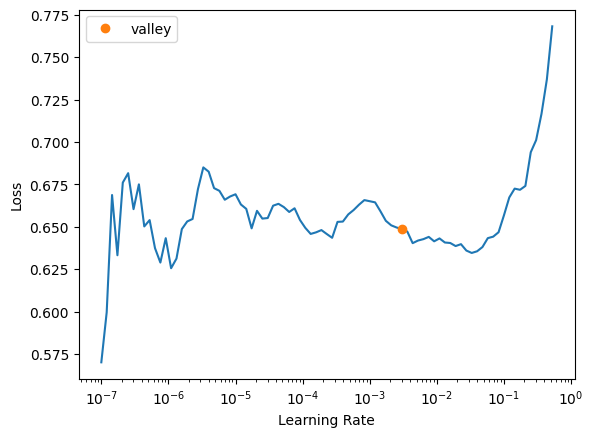

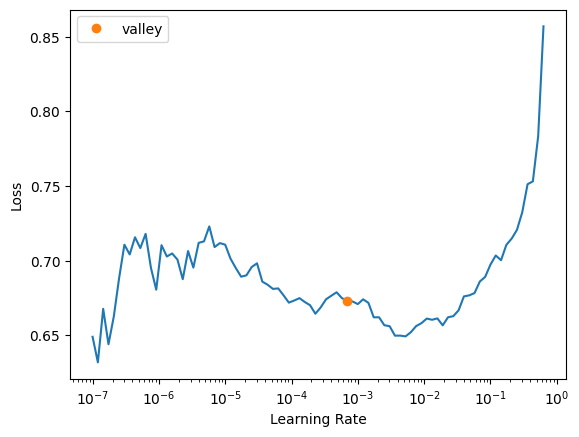

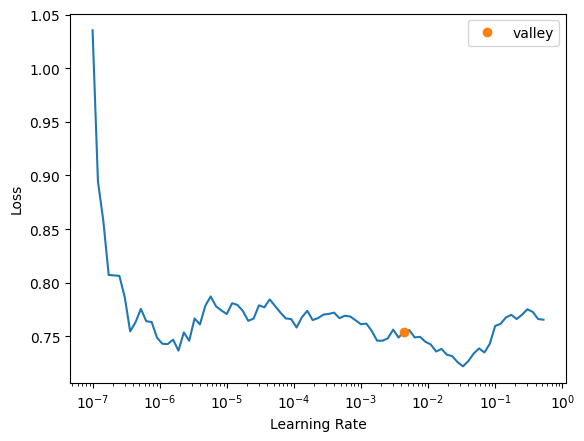

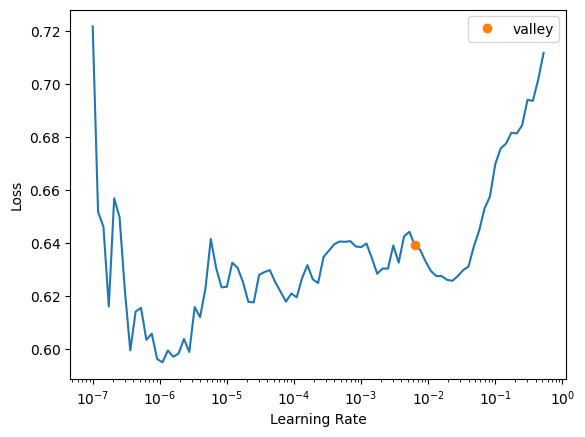

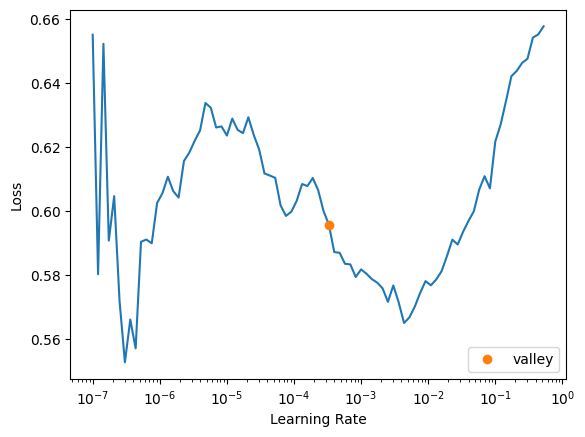

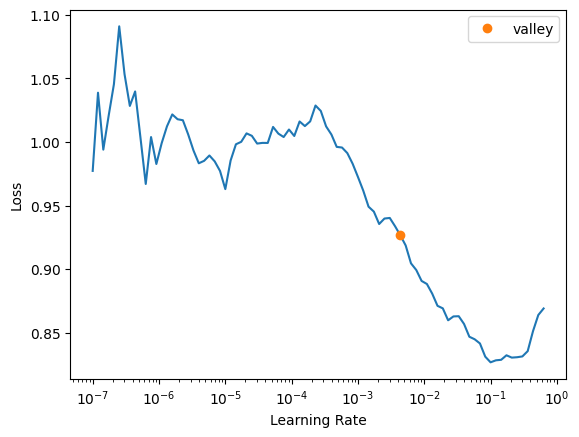

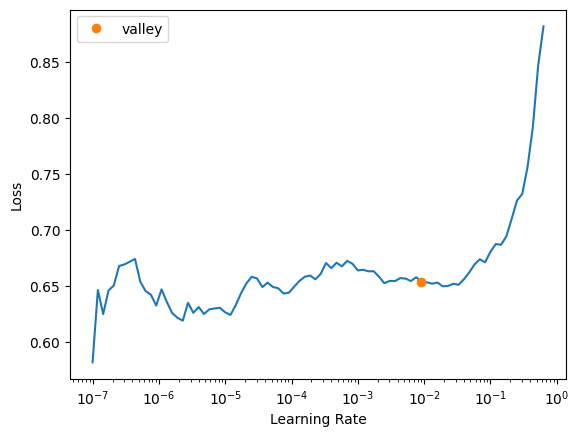

In [33]:
# Working ???
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]),  max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-ILS-GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS-GD'], f)

file_path = f'/notebooks/saved_models/SHADE-ILS-GD_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS-GD'], f)


In [38]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [39]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][layer]) - np.array(results['SHADE-ILS-GD'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][layer])
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for 1 layers: [35.83933639526367, 0.6107494235038757, 0.6053186655044556, 0.5990769863128662, 0.5990769863128662, 0.5990769863128662, 0.5938937664031982, 0.5938937664031982, 0.5938937664031982, 0.5938937664031982, 0.5861675143241882, 0.5688470005989075, 0.5664059519767761, 0.5661646723747253, 0.5661646723747253, 0.5661646723747253, 0.5661646723747253, 0.5661646723747253, 0.5661646723747253, 0.559714674949646, 0.559714674949646]
Validation error of SHADE-ILS-GD for 1 layers: [38.9868278503418, 0.7085713148117065, 0.7085713148117065, 0.6946552395820618, 0.6946552395820618, 0.6946552395820618, 0.7245226502418518, 0.7245226502418518, 0.7245226502418518, 0.7245226502418518, 0.7073574662208557, 0.6973283886909485, 0.6961541175842285, 0.6961541175842285, 0.6961541175842285, 0.6961541175842285, 0.6961541175842285, 0.6961541175842285, 0.6961541175842285, 0.7101474404335022, 0.7101474404335022]
Difference: [3.14749146 0.09782189 0.10325265 0.09557825 0.09557825 0.0

### Save or load

In [39]:
#Save the mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [30]:
#Load the trained mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)

### Comparison between MH

In [40]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for layer in n_layers:
  training['SHADE'][layer] = results['SHADE'][layer][6]
  training['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2]
  training['SHADE-GD'][layer] = results['SHADE-GD'][layer][2]
  training['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][2]

In [30]:
#Calculate r2sq
r2sq = {}
#f1score = {}
for mh in algs:
  #f1score[mh] = {}
  r2sq[mh] = {}
  for layer in n_layers:
    #1score[mh][layer] = []
    r2sq[mh][layer] = []
    ind = 5 if mh == 'SHADE' else 3
    start = time.perf_counter()
    for model in results[mh][layer][ind]:
      utilsTFG.set_params_to_model(model, mh_learners[layer].model)
      mh_learners[layer].model.eval()
      mh_learners[layer].eval()
      preds, targs = mh_learners[layer].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      r2sq[mh][layer].append(utilsTFG.adjusted_r2_score(preds, targs))
    end = time.perf_counter()
    #time_full_mh[mh][layer]+= end-start


<Figure size 1200x600 with 0 Axes>

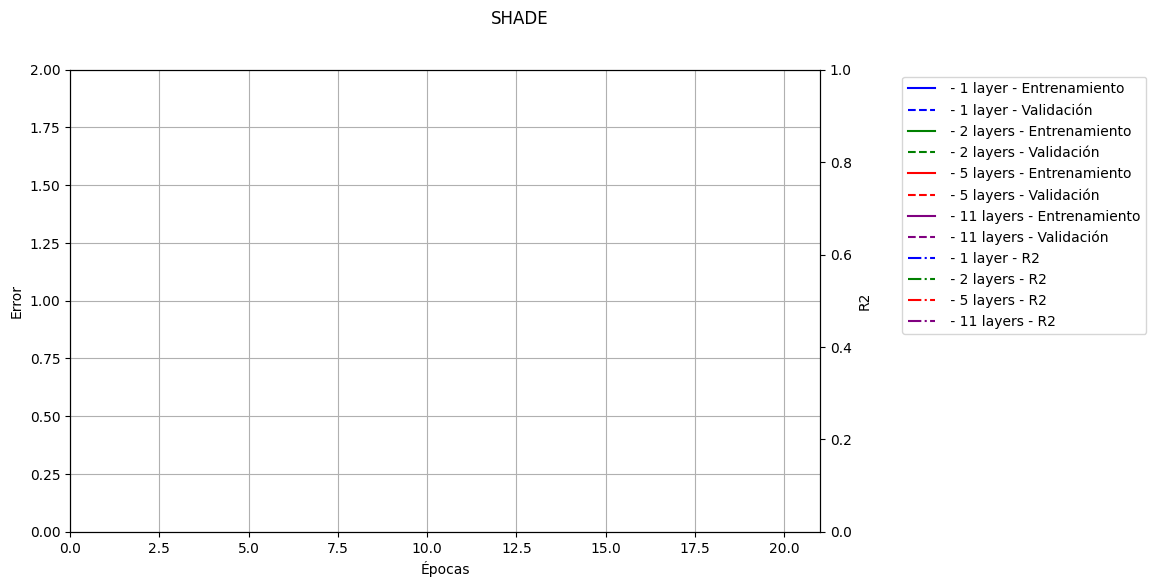

<Figure size 1200x600 with 0 Axes>

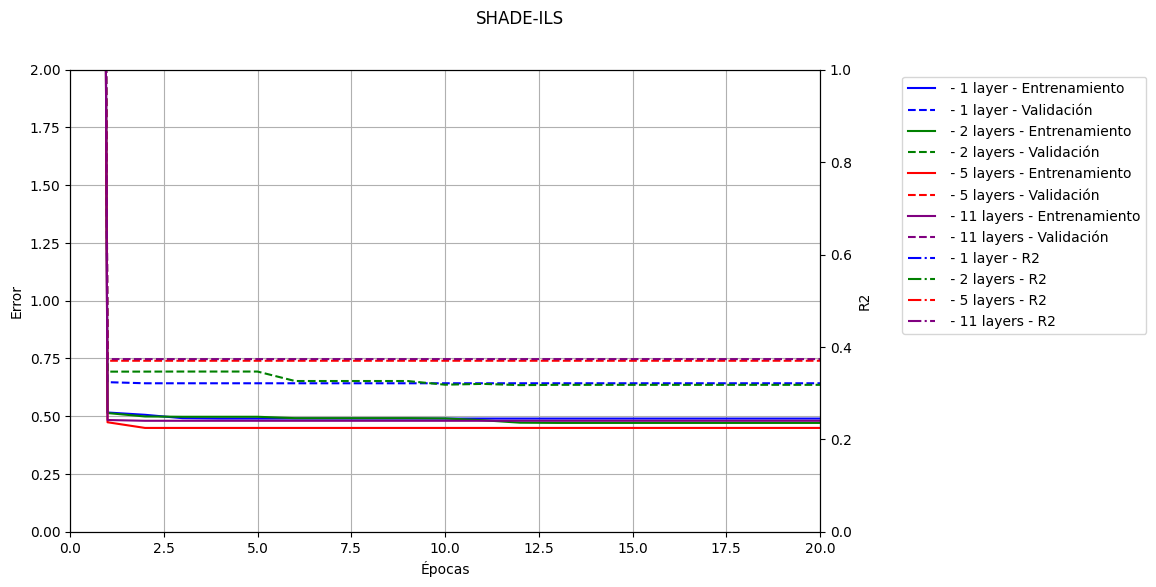

<Figure size 1200x600 with 0 Axes>

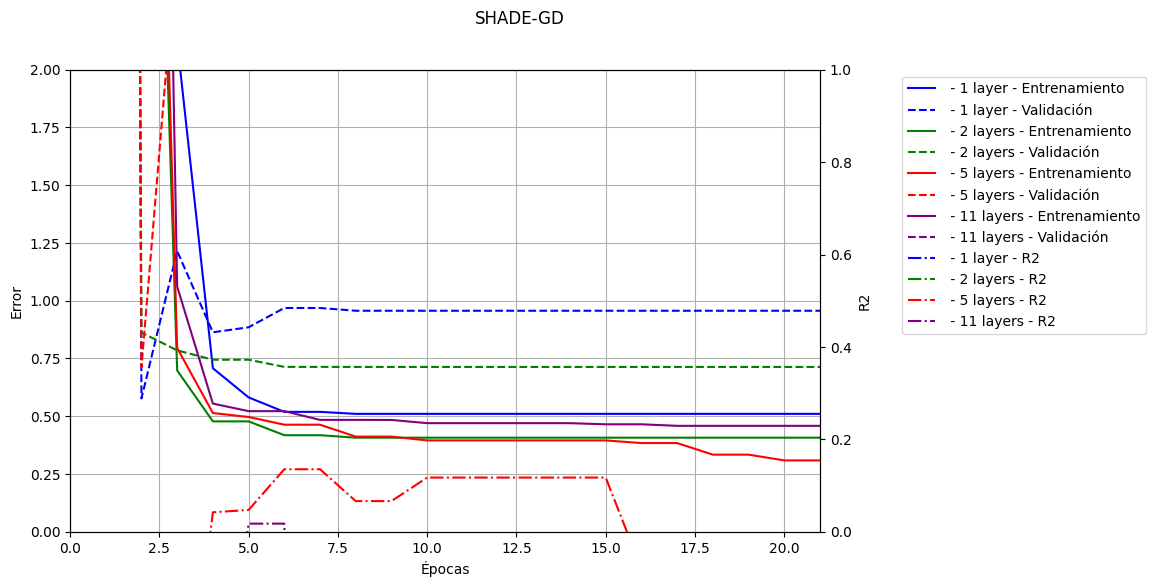

<Figure size 1200x600 with 0 Axes>

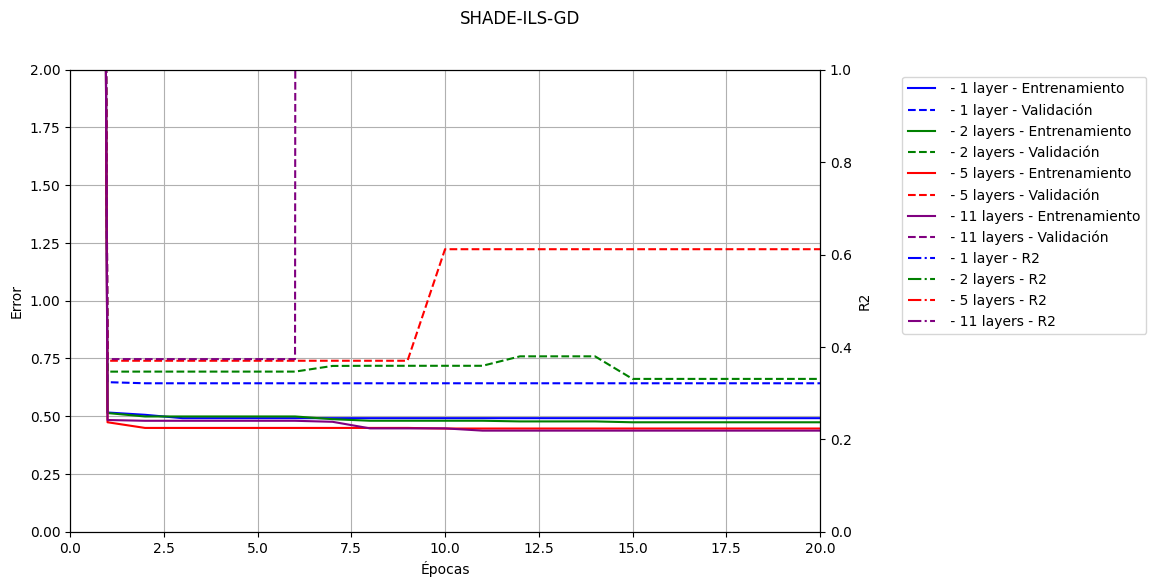

In [31]:
#Comparing the different layers version of the same MH
names= ['1 layer', '2 layers', '5 layers', '11 layers']
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], r2sq[alg], lim = 2, metric = ['R2'], layers = n_layers, names=names, title=f'{alg}')

<Figure size 1200x600 with 0 Axes>

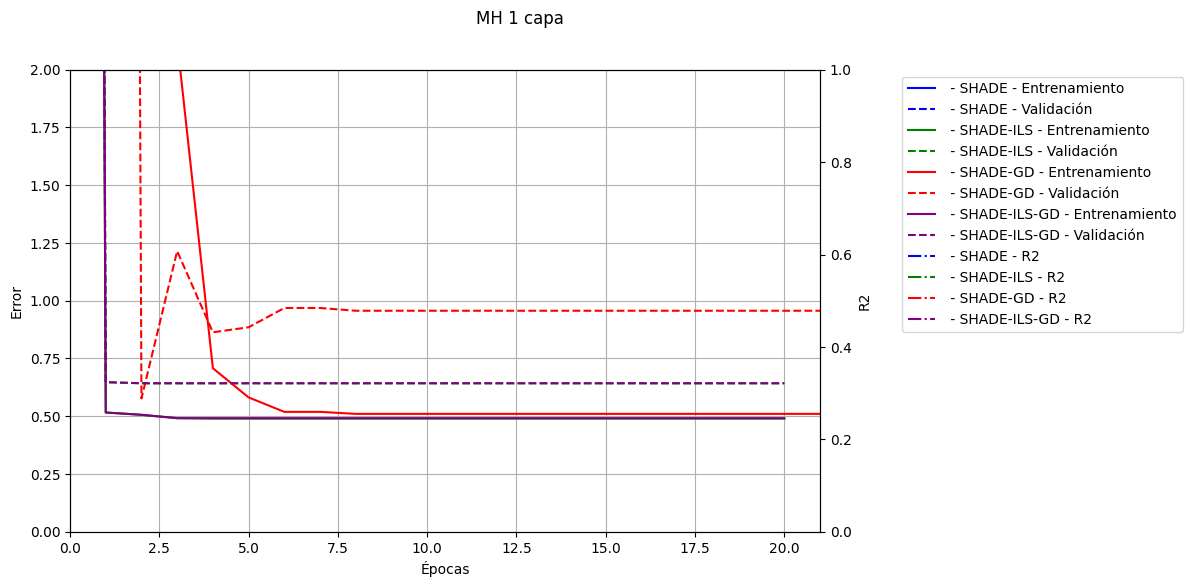

<Figure size 1200x600 with 0 Axes>

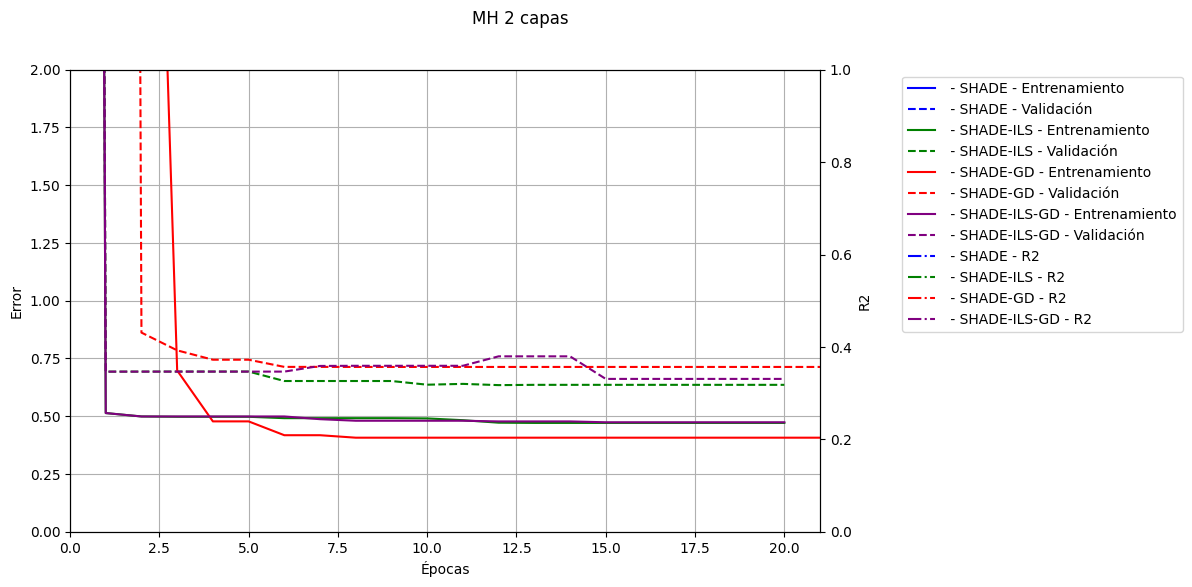

<Figure size 1200x600 with 0 Axes>

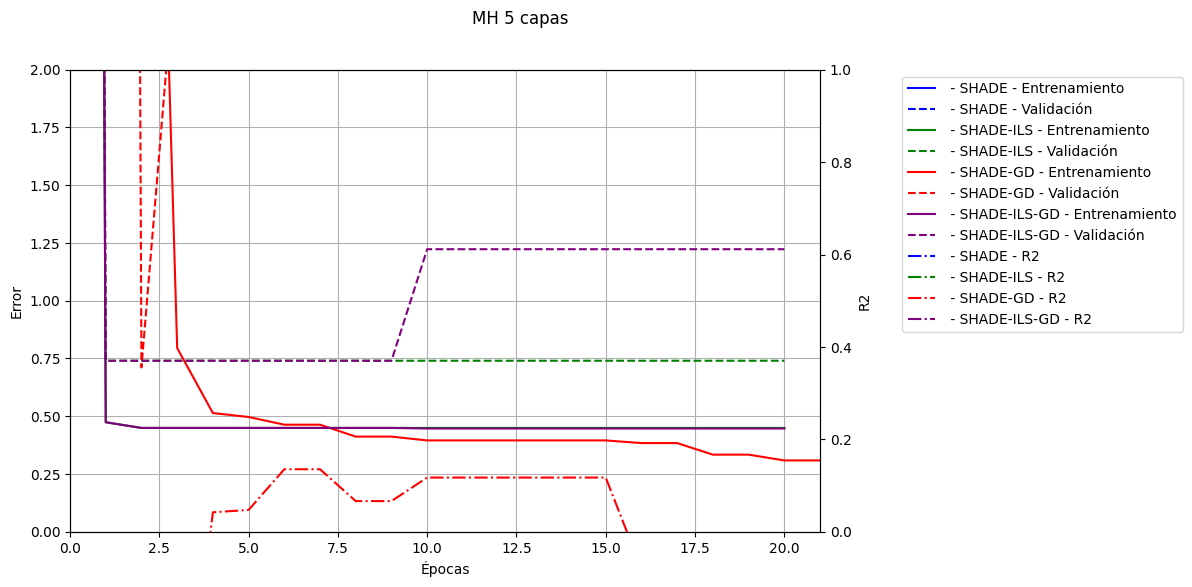

<Figure size 1200x600 with 0 Axes>

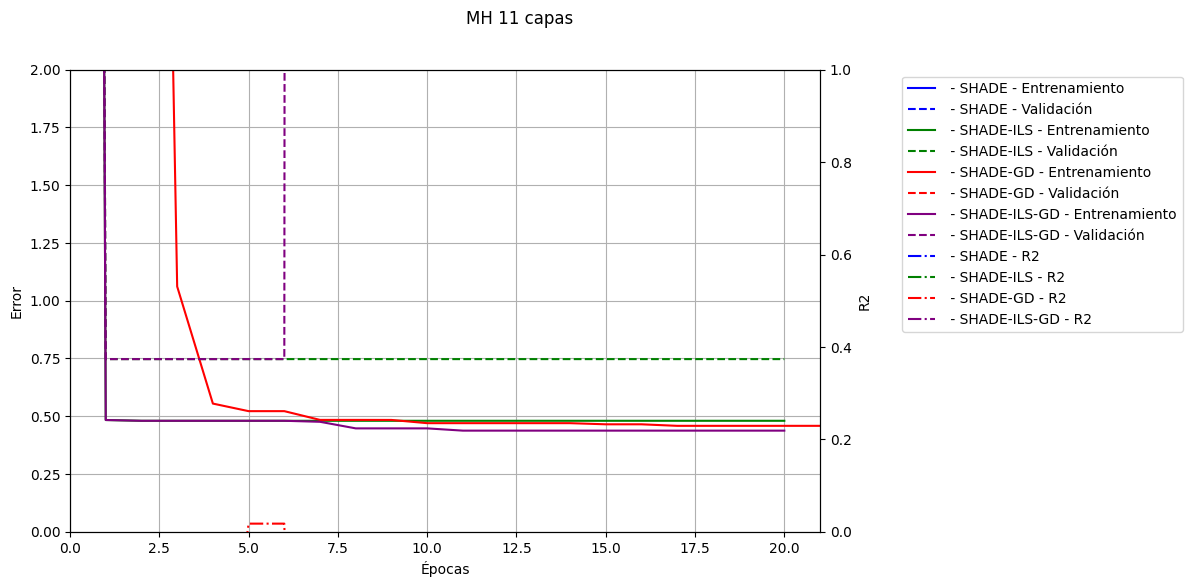

In [32]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
r2 = {}
valid = {}
for layer in n_layers:
  train[layer] = {}
  r2[layer] = {}
  valid[layer] = {}
  for alg in algs:
    train[layer][alg] = training[alg][layer]
    r2[layer][alg] = r2sq[alg][layer]
    valid[layer][alg] = fitness_valid[alg][layer]
  c = 'capa' if layer==1 else 'capas'
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], r2[layer], lim = 2, metric = ['R2'], layers = names, names=names, title=f'MH {layer} {c}')

### Generalization

In [41]:
#Run the model in the test set
for mh in algs:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][layer], mh_learners[layer].model)
    mh_learners[layer].model.eval()
    mh_learners[layer].eval()
    preds, targs = mh_learners[layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate balanced accuracy

    ac = utilsTFG.adjusted_r2_score(preds, targs)

    #Calculate F1-Score
    #f1 = utilsTFG.f1_score_func(preds, targs)

    loss = utilsTFG.err_param_w_model(mh_learners[layer].model, test_dl, mode = 'test', task='reg')

    print(f"Optimizer: {mh}, Layers: {layer}, Loss: {loss}, R2 Square: {ac}")

Optimizer: SHADE, Layers: 1, Loss: 34.33574295043945, R2 Square: -415.0639579076194


Optimizer: SHADE, Layers: 2, Loss: 30.955753326416016, R2 Square: -2020.267015143085


Optimizer: SHADE, Layers: 5, Loss: 32.230690002441406, R2 Square: -213543.9237657767


Optimizer: SHADE, Layers: 11, Loss: 32.1755256652832, R2 Square: -1950544.4254451494


Optimizer: SHADE-ILS, Layers: 1, Loss: 0.969723641872406, R2 Square: -1.9866681556700376


Optimizer: SHADE-ILS, Layers: 2, Loss: 0.825999915599823, R2 Square: -2.490913604618984


Optimizer: SHADE-ILS, Layers: 5, Loss: 0.7237338423728943, R2 Square: -983.152051826326


Optimizer: SHADE-ILS, Layers: 11, Loss: 0.7338342070579529, R2 Square: -79529.60235860255


Optimizer: SHADE-GD, Layers: 1, Loss: 0.7121357917785645, R2 Square: -2.623759028973246


Optimizer: SHADE-GD, Layers: 2, Loss: 1.5483438968658447, R2 Square: -0.4415939221844658


Optimizer: SHADE-GD, Layers: 5, Loss: 0.9340226650238037, R2 Square: -3.4466599634985737


Optimizer: SHADE-GD, Layers: 11, Loss: 32.03908920288086, R2 Square: -231156.24220691732


Optimizer: SHADE-ILS-GD, Layers: 1, Loss: 0.9124380946159363, R2 Square: -1.898293455707488


Optimizer: SHADE-ILS-GD, Layers: 2, Loss: 0.6202105283737183, R2 Square: -4.104812237138213


Optimizer: SHADE-ILS-GD, Layers: 5, Loss: 0.7473446726799011, R2 Square: -234.73474047173264


Optimizer: SHADE-ILS-GD, Layers: 11, Loss: 0.7338342070579529, R2 Square: -79529.60235860255


## Time comparison

In [40]:
#Compare times for each algorithm and layer

#GD
for alg, time_layers in time_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

#MH
for optims, time_layers in time_gd.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {optims} training with {layer} layers: {time:.04f} seconds')



Time consumed by SHADE training with 1 layers: 689.9419 seconds
Time consumed by SHADE training with 2 layers: 745.0851 seconds
Time consumed by SHADE training with 5 layers: 942.5054 seconds
Time consumed by SHADE training with 11 layers: 1906.0667 seconds
Time consumed by SHADE-ILS training with 1 layers: 784.1190 seconds
Time consumed by SHADE-ILS training with 2 layers: 854.9505 seconds
Time consumed by SHADE-ILS training with 5 layers: 1121.0694 seconds
Time consumed by SHADE-ILS training with 11 layers: 2051.4801 seconds
Time consumed by SHADE-GD training with 1 layers: 701.7391 seconds
Time consumed by SHADE-GD training with 2 layers: 757.5306 seconds
Time consumed by SHADE-GD training with 5 layers: 946.6872 seconds
Time consumed by SHADE-GD training with 11 layers: 1892.0113 seconds
Time consumed by SHADE-ILS-GD training with 1 layers: 722.1208 seconds
Time consumed by SHADE-ILS-GD training with 2 layers: 788.9011 seconds
Time consumed by SHADE-ILS-GD training with 5 layers: 9

In [22]:
for alg, time_layers in time_full_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.03f} seconds')

Time consumed by SHADE training with 1 layers: 697.633 seconds
Time consumed by SHADE training with 2 layers: 753.746 seconds
Time consumed by SHADE training with 5 layers: 950.852 seconds
Time consumed by SHADE training with 11 layers: 1916.133 seconds
Time consumed by SHADE-ILS training with 1 layers: 785.936 seconds
Time consumed by SHADE-ILS training with 2 layers: 856.806 seconds
Time consumed by SHADE-ILS training with 5 layers: 1123.316 seconds
Time consumed by SHADE-ILS training with 11 layers: 2054.672 seconds
